In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt

import scipy as sp
#import statsmodels.tsa.api as smt
#import statsmodels.api as sm
#from itertools import product
import warnings
#warnings.filterwarnings('ignore')

%matplotlib inline

from random import randrange,randint 
from scipy.optimize import curve_fit
import math as math
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error

In [2]:
# Useful functions
def plot_series(time, series, format='-', start=0, end=None):
        plt.plot(time[start:end], series[start:end], format)
        plt.xlabel("Time")
        plt.ylabel("Value")
        plt.grid(True)

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred)/y_true))*100

In [3]:
# Useful functions
def region_class_value_specific_df(df, cl, region, min_year = 2002, max_year = 2019 ,wanted_columns = ["class_name","region_name", "variable_name", "date", "value", "year"]):
    year_threshold = dt.datetime(2001, 12, 30)
    
    year_2015 = dt.datetime(2015, 12, 30) # y, m, d 
    year_2001 = dt.datetime(2001, 12, 30) # y, m, d 
    max_year = dt.datetime(2020, 1, 1) # y, m, d 
    year_threshold = year_2001
    if min_year == 2016:
        year_threshold = year_2015
    if min_year != 2016 and min_year!= 2002:
        warnings.warn("This year is not in the list, setting it to min 2002 instead") 
        
    selected_subset_df = df.loc[(df["class_name"] == cl) &  (df["region_name"] == region) &  (df["date"] > year_threshold) & (df["date"] < max_year), wanted_columns]
    df_ndvi = selected_subset_df.loc[(df["variable_name"] == "NDVI")]
    df_temperature = selected_subset_df.loc[(df["variable_name"] == "Temperature")]
    df_rainfall = selected_subset_df.loc[(df["variable_name"] == "Rainfall")]

    df_ndvi.sort_values(by=['date'])
    df_temperature.sort_values(by=['date'])
    df_rainfall.sort_values(by=['date'])

    df_ndvi.reset_index(inplace=True)
    df_temperature.reset_index(inplace=True)
    df_rainfall.reset_index(inplace=True)
    return df_ndvi, df_temperature, df_rainfall

In [4]:
asap_file_path = '/Users/eakilli/Desktop/Omdena/GPSDD-Food-Security-Senegal/data/external/SEN_asap_region.csv'
yield_file_path = '../../src/data/task4_generate_sw_build_gt/senegal_regions_yields_standardized.csv'

In [5]:
asap_file = pd.read_csv(asap_file_path, parse_dates=['date'])
asap_file.head(2)

,Unnamed: 0,region_name,variable_name,sensor_name,class_name,date,value,year,month,day,yearday
0,0,Kolda,Temperature,ECMWF,Rangeland during growing cycle,1989-01-01,25.302,1989,1,1,1
1,1,Kolda,Temperature,ECMWF,Rangeland during growing cycle,1989-01-11,26.047,1989,1,11,11


In [6]:
print(asap_file['variable_name'].unique())

# First get the Kaffrine, crop dataset
#crop_Kaffrine_ndvi, crop_Kaffrine_temperature, crop_Kaffrine_rainfall = region_class_value_specific_df(df = asap_file, cl = "Crop", region = "Kaffrine", min_year = 2016, max_year = 2019)

['Temperature' 'NDVI Cumulated - zscore' 'SPI - 3 months'
 'Water Satisfaction Index (WSI)' 'NDVI - zscore' 'NDVI' 'Rainfall']


In [7]:
def choose_week_window_value(df_element, min_week=0, max_week=36):
    arr = df_element['value']
    arr = arr[min_week:max_week]
    t = np.array(range(len(arr)))
    return arr, t

def choose_week_window_ndvi(df_element, min_week=0, max_week=36):
    ndvi = df_element['ndvi']
    ndvi = ndvi[min_week:max_week]
    t = np.array(range(len(ndvi)))
    return ndvi, t

In [8]:
def plot_ndvis(df_element, min_week=0, max_week=46, fitted_curve=None, index_fitted_curve=None):
    fig = plt.figure(figsize=(4,4))
    nth_8days = df_element['t_indices']
    ndvi = df_element['ndvi']
    plt.plot(nth_8days[min_week:max_week] , ndvi[min_week:max_week])
    if fitted_curve!= None:
        print(fitted_curve)
        plt.plot(index_fitted_curve, fitted_curve)
    plt.ylabel('NDVI')
    plt.xlabel('Nth 10 days')
    plt.title('Region: {}'.format(df_element['region_name']), fontsize=8)

This data does not have the resolution to be affected by the clouds, etc and is not as noisy. So removed the Fourier fit for now since overall it actually makes things worse due to unsuccessful fits. 

In [9]:
min_w = 24
max_w = 30

region_list = asap_file["region_name"].unique()

list_of_regions = []
list_of_ndvi_arrays = []

list_of_dates = []
list_of_years = []
list_of_subset_ndvi = []
list_of_ndvi_indices = []
max_ndvi_list = []
sum_ndvi_list = []


# Generalize to get crop ndvi, temperature, rainfall for all regions 
for i in range(len(region_list)):
    current_region = region_list[i]
    crop_region_ndvi_allyears, crop_region_temperature_allyears, crop_region_rainfall_allyears = region_class_value_specific_df(df = asap_file, 
                                                                   cl = "Crop", region = current_region, 
                                                                   min_year = 2016, max_year = 2019)
    year_list = crop_region_ndvi_allyears["year"].unique()
    for j in range(len(year_list)):
        year = year_list[j]
    
        crop_region_ndvi = crop_region_ndvi_allyears.loc[crop_region_ndvi_allyears['year'] == year]
        current_ndvi_array = crop_region_ndvi['value'].to_numpy()
        current_ndvi_date_array = crop_region_ndvi['date'].to_numpy()
        current_ndvi_index_array = np.array(range(len(current_ndvi_date_array)))
        
        contains_nan_ndvi = np.isnan(np.min(current_ndvi_array))
        contains_nan_ndvi_date = np.isnan(np.min(current_ndvi_date_array))
    
        # Check for nans 
        if contains_nan_ndvi or contains_nan_ndvi_date:
            print("There is nan value for key: {}. Skipping this one...".format(k))
            continue 
        
        list_of_regions.append(current_region)
        list_of_ndvi_arrays.append(current_ndvi_array)
        list_of_dates.append(current_ndvi_date_array)
        list_of_ndvi_indices.append(current_ndvi_index_array)
        list_of_years.append(year)
        max_ndvi_list.append(max(current_ndvi_array))
        sum_ndvi_list.append(sum(current_ndvi_array))
        
        # Subset, windows of 10 days 
        windowed_ndvi, t_index = choose_week_window_value(crop_region_ndvi, min_week=min_w, max_week=max_w)
        list_of_subset_ndvi.append(windowed_ndvi.to_numpy())
        

#regionwise_df = pd.DataFrame({'region_name': list_of_regions, 'year': list_of_years, 'ndvi':  list_of_ndvi_arrays, 'date': list_of_dates,'t_indices': list_of_t_indices,'ndvi_fit': ndvi_fit_list,'max_fit_ndvi': max_curve_list, 'max_ndvi' : max_ndvi_list, 'fit_r2': fit_r2_list})
regionwise_df_ndvi = pd.DataFrame({'region_name': list_of_regions, 'year': list_of_years, 'ndvi':  list_of_ndvi_arrays, 
                              'date': list_of_dates,'ndvi_indices': list_of_ndvi_indices,
                              'ndvi_window': list_of_subset_ndvi, 'max_ndvi' : max_ndvi_list, 'sum_ndvi': sum_ndvi_list})


In [10]:
list_of_regions = []
list_of_rainfall_arrays = []
list_of_dates = []
list_of_years = []
list_of_subset_rainfall = []
list_of_rainfall_indices = []
max_rainfall_list = []
sum_rainfall_list = []

# Generalize to get crop rainfall, temperature, rainfall for all regions 
for i in range(len(region_list)):
    current_region = region_list[i]
    crop_region_ndvi_allyears, crop_region_temperature_allyears, crop_region_rainfall_allyears = region_class_value_specific_df(df = asap_file, 
                                                                   cl = "Crop", region = current_region, 
                                                                   min_year = 2016, max_year = 2019)
    year_list = crop_region_rainfall_allyears["year"].unique()
    for j in range(len(year_list)):
        year = year_list[j]
    
        crop_region_rainfall = crop_region_rainfall_allyears.loc[crop_region_rainfall_allyears['year'] == year]
        current_rainfall_array = crop_region_rainfall['value'].to_numpy()
        current_rainfall_date_array = crop_region_rainfall['date'].to_numpy()
        current_rainfall_index_array = np.array(range(len(current_rainfall_date_array)))
        
        contains_nan_rainfall = np.isnan(np.min(current_rainfall_array))
        contains_nan_rainfall_date = np.isnan(np.min(current_rainfall_date_array))
    
        # Check for nans 
        if contains_nan_rainfall or contains_nan_rainfall_date:
            print("There is nan value for key: {}. Skipping this one...".format(k))
            continue 
        
        list_of_regions.append(current_region)
        list_of_rainfall_arrays.append(current_rainfall_array)
        list_of_dates.append(current_rainfall_date_array)
        list_of_rainfall_indices.append(current_rainfall_index_array)
        list_of_years.append(year)
        max_rainfall_list.append(max(current_rainfall_array))
        sum_rainfall_list.append(sum(current_rainfall_array))
        
        # Subset, windows of 10 days 
        windowed_rainfall, t_index = choose_week_window_value(crop_region_rainfall, min_week=min_w, max_week=max_w)
        list_of_subset_rainfall.append(windowed_rainfall.to_numpy())
        

regionwise_df_rainfall = pd.DataFrame({'region_name': list_of_regions, 'year': list_of_years, 
                                       'rainfall':  list_of_rainfall_arrays, 
                                       'date': list_of_dates,'rainfall_indices': list_of_rainfall_indices,
                                       'rainfall_window': list_of_subset_rainfall, 
                                       'max_rainfall' : max_rainfall_list, 'sum_rainfall': sum_rainfall_list})

In [11]:
list_of_regions = []
list_of_temperature_arrays = []
list_of_dates = []
list_of_years = []
list_of_subset_temperature = []
list_of_temperature_indices = []
max_temperature_list = []
sum_temperature_list = []



# Generalize to get crop temperature, temperature, temperature for all regions 
for i in range(len(region_list)):
    current_region = region_list[i]
    crop_region_ndvi_allyears, crop_region_temperature_allyears, crop_region_rainfall_allyears = region_class_value_specific_df(df = asap_file, 
                                                                   cl = "Crop", region = current_region, 
                                                                   min_year = 2016, max_year = 2019)
    year_list = crop_region_temperature_allyears["year"].unique()
    for j in range(len(year_list)):
        year = year_list[j]
    
        crop_region_temperature = crop_region_temperature_allyears.loc[crop_region_temperature_allyears['year'] == year]
        current_temperature_array = crop_region_temperature['value'].to_numpy()
        current_temperature_date_array = crop_region_temperature['date'].to_numpy()
        current_temperature_index_array = np.array(range(len(current_temperature_date_array)))
        
        contains_nan_temperature = np.isnan(np.min(current_temperature_array))
        contains_nan_temperature_date = np.isnan(np.min(current_temperature_date_array))
    
        # Check for nans 
        if contains_nan_temperature or contains_nan_temperature_date:
            print("There is nan value for key: {}. Skipping this one...".format(k))
            continue 
        
        list_of_regions.append(current_region)
        list_of_temperature_arrays.append(current_temperature_array)
        list_of_dates.append(current_temperature_date_array)
        list_of_temperature_indices.append(current_temperature_index_array)
        list_of_years.append(year)
        max_temperature_list.append(max(current_temperature_array))
        sum_temperature_list.append(sum(current_temperature_array))
        
        # Subset, windows of 10 days 
        windowed_temperature, t_index = choose_week_window_value(crop_region_temperature, min_week=min_w, max_week=max_w)
        list_of_subset_temperature.append(windowed_temperature.to_numpy())
        

regionwise_df_temperature = pd.DataFrame({'region_name': list_of_regions, 'year': list_of_years, 'temperature':  list_of_temperature_arrays, 
                              'date': list_of_dates,'temperature_indices': list_of_temperature_indices,
                              'temperature_window': list_of_subset_temperature, 'max_temperature' : max_temperature_list, 'sum_temperature': sum_temperature_list})

In [12]:
regionwise_df = regionwise_df_ndvi.merge(regionwise_df_rainfall, how='left', on=['region_name','year'])

In [13]:
regionwise_df= regionwise_df.merge(regionwise_df_temperature, how='left', on=['region_name','year'])

In [14]:
regionwise_df.head(3)

,region_name,year,ndvi,date_x,ndvi_indices,ndvi_window,max_ndvi,sum_ndvi,rainfall,date_y,rainfall_indices,rainfall_window,max_rainfall,sum_rainfall,temperature,date,temperature_indices,temperature_window,max_temperature,sum_temperature
0,Kolda,2016,"[0.406, 0.378, 0.348, 0.32299999999999995, 0.3...","[2016-01-01T00:00:00.000000000, 2016-01-11T00:...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.713, 0.7390000000000001, 0.742, 0.721, 0.68...",0.742,16.067,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2016-01-01T00:00:00.000000000, 2016-01-11T00:...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[78.71600000000002, 140.433, 105.154, 7.872999...",140.433,897.039,"[25.773000000000003, 26.992, 27.198, 27.295, 2...","[2016-01-01T00:00:00.000000000, 2016-01-11T00:...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[26.794, 26.67, 26.873, 28.175, 28.48, 28.586]",32.763,1033.126
1,Kolda,2017,"[0.363, 0.344, 0.324, 0.307, 0.295, 0.28800000...","[2017-01-01T00:00:00.000000000, 2017-01-11T00:...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.718, 0.715, 0.7, 0.6759999999999999, 0.643,...",0.718,15.912,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2017-01-01T00:00:00.000000000, 2017-01-11T00:...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[43.99800000000001, 46.267, 37.368, 17.18, 10....",205.006,944.771,"[26.866, 26.267, 27.191, 28.003, 29.517, 30.92...","[2017-01-01T00:00:00.000000000, 2017-01-11T00:...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[27.074, 27.86, 27.849, 28.08, 28.814, 29.902]",32.952,1042.414
2,Kolda,2018,"[0.334, 0.321, 0.31, 0.3, 0.29, 0.283000000000...","[2018-01-01T00:00:00.000000000, 2018-01-11T00:...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.726, 0.735, 0.736, 0.7290000000000001, 0.71...",0.736,16.089,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2018-01-01T00:00:00.000000000, 2018-01-11T00:...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[145.994, 67.26, 60.527, 56.825, 16.787, 3.154]",145.994,873.700,"[26.312, 25.784, 27.062, 26.772, 29.333, 28.54...","[2018-01-01T00:00:00.000000000, 2018-01-11T00:...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[25.971, 26.985, 26.771, 27.679, 27.814, 29.127]",32.138,1028.627


In [15]:
for x in range(regionwise_df.shape[0]):
    
    each = regionwise_df.loc[x]
    
    A = each['date_x']
    B = each['date_y']
    C = each['date']
    
    A_B = (A==B).all()
    B_C = (B==C).all()
    A_C = (A==C).all() # this one not really necessary...
    comp = A_B or B_C or A_C   

    if not comp:
        warnings.warn('Dates are not the same!')

regionwise_df.drop(columns=['date_x', 'date_y'])        

,region_name,year,ndvi,ndvi_indices,ndvi_window,max_ndvi,sum_ndvi,rainfall,rainfall_indices,rainfall_window,max_rainfall,sum_rainfall,temperature,date,temperature_indices,temperature_window,max_temperature,sum_temperature
0,Kolda,2016,"[0.406, 0.378, 0.348, 0.32299999999999995, 0.3...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.713, 0.7390000000000001, 0.742, 0.721, 0.68...",0.742,16.067,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[78.71600000000002, 140.433, 105.154, 7.872999...",140.433,897.039,"[25.773000000000003, 26.992, 27.198, 27.295, 2...","[2016-01-01T00:00:00.000000000, 2016-01-11T00:...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[26.794, 26.67, 26.873, 28.175, 28.48, 28.586]",32.763,1033.126
1,Kolda,2017,"[0.363, 0.344, 0.324, 0.307, 0.295, 0.28800000...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.718, 0.715, 0.7, 0.6759999999999999, 0.643,...",0.718,15.912,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[43.99800000000001, 46.267, 37.368, 17.18, 10....",205.006,944.771,"[26.866, 26.267, 27.191, 28.003, 29.517, 30.92...","[2017-01-01T00:00:00.000000000, 2017-01-11T00:...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[27.074, 27.86, 27.849, 28.08, 28.814, 29.902]",32.952,1042.414
2,Kolda,2018,"[0.334, 0.321, 0.31, 0.3, 0.29, 0.283000000000...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.726, 0.735, 0.736, 0.7290000000000001, 0.71...",0.736,16.089,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[145.994, 67.26, 60.527, 56.825, 16.787, 3.154]",145.994,873.700,"[26.312, 25.784, 27.062, 26.772, 29.333, 28.54...","[2018-01-01T00:00:00.000000000, 2018-01-11T00:...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[25.971, 26.985, 26.771, 27.679, 27.814, 29.127]",32.138,1028.627
3,Kolda,2019,"[0.382, 0.361, 0.338, 0.317, 0.299, 0.289, 0.2...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.748, 0.764, 0.7659999999999999, 0.753, 0.72...",0.766,16.382,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[79.57300000000002, 92.226, 76.005, 43.359, 27...",138.403,869.325,"[26.195, 26.208, 26.255, 28.534, 29.651, 28.82...","[2019-01-01T00:00:00.000000000, 2019-01-11T00:...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[26.673, 26.621, 27.245, 27.14, 28.009, 27.951]",33.279,1033.872
4,Fatick,2016,"[0.279, 0.267, 0.256, 0.247, 0.241, 0.238, 0.2...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.528, 0.568, 0.5760000000000001, 0.552999999...",0.576,11.136,"[0.514, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[81.669, 73.304, 74.703, 1.4469999999999998, 3...",106.004,523.877,"[24.792, 26.666, 26.762, 26.199, 25.853, 27.71...","[2016-01-01T00:00:00.000000000, 2016-01-11T00:...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[27.632, 26.892, 27.753, 28.669, 28.91, 29.199]",30.639,981.905
5,Fatick,2017,"[0.263, 0.257, 0.25, 0.245, 0.241, 0.237, 0.23...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.591, 0.579, 0.5489999999999999, 0.504, 0.45...",0.591,11.550,"[0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[37.195, 26.189, 18.449, 8.729, 4.79, 1.755]",104.397,535.784,"[25.484, 24.091, 24.394, 25.33, 25.119, 26.946...","[2017-01-01T00:00:00.000000000, 2017-01-11T00:...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[27.708, 28.57, 28.291, 28.908, 29.504, 29.941]",30.846,987.241
6,Fatick,2018,"[0.255, 0.249, 0.242, 0.237, 0.234, 0.231, 0.2...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.5529999999999999, 0.574, 0.5770000000000001...",0.577,11.404,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[104.324, 28.381, 29.814, 16.82, 4.025, 1.

In [16]:
regionwise_df.describe(include='all')

,region_name,year,ndvi,date_x,ndvi_indices,ndvi_window,max_ndvi,sum_ndvi,rainfall,date_y,rainfall_indices,rainfall_window,max_rainfall,sum_rainfall,temperature,date,temperature_indices,temperature_window,max_temperature,sum_temperature
count,56,56.000000,56,56,56,56,56.000000,56.000000,56,56,56,56,56.000000,56.000000,56,56,56,56,56.000000,56.000000
unique,14,NaN,56,56,56,56,NaN,NaN,56,56,56,56,NaN,NaN,56,56,56,56,NaN,NaN
top,Fatick,NaN,"[0.239, 0.233, 0.228, 0.224, 0.22, 0.218, 0.21...","[2018-01-01T00:00:00.000000000, 2018-01-11T00:...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.37, 0.393, 0.401, 0.393, 0.377, 0.358]",NaN,NaN,"[0.0, 0.0, 0.0, 0.049, 0.103, 0.0, 0.0, 0.0, 0...","[2018-01-01T00:00:00.000000000, 2018-01-11T00:...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[43.034, 33.478, 24.827, 6.277, 3.944, 2.78800...",NaN,NaN,"[23.947, 22.512, 22.965, 21.197, 24.9530000000...","[2018-01-01T00:00:00.000000000, 2018-01-11T00:...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[28.63, 29.198, 29.583, 31.188, 29.84800000000...",NaN,NaN
freq,4,NaN,1,1,1,1,NaN,NaN,1,1,1,1,NaN,NaN,1,1,1,1,NaN,NaN
mean,NaN,2017.500000,NaN,NaN,NaN,NaN,0.614036,12.986661,NaN,NaN,NaN,NaN,118.217911,611.914536,NaN,NaN,NaN,NaN,31.153839,995.007161
std,NaN,1.128152,NaN,NaN,NaN,NaN,0.110501,3.186410,NaN,NaN,NaN,NaN,43.257438,302.159237,NaN,NaN,NaN,NaN,2.086659,48.198527
min,NaN,2016.000000,NaN,NaN,NaN,NaN,0.357000,9.348000,NaN,NaN,NaN,NaN,36.932000,174.866000,NaN,NaN,NaN,NaN,28.000000,869.270000
25%,NaN,2016.750000,NaN,NaN,NaN,NaN,0.539750,10.599500,NaN,NaN,NaN,NaN,91.878250,389.733250,NaN,NaN,NaN,NaN,29.551250,968.655500
50%,NaN,2017.500000,NaN,NaN,NaN,NaN,0.616500,11.544000,NaN,NaN,NaN,NaN,107.633500,527.249500,NaN,NaN,NaN,NaN,31.061000,989.480500
75%,NaN,2018.250000,NaN,NaN,NaN,NaN,0.709000,16.072500,NaN,NaN,NaN,NaN,147.017250,879.534750,NaN,NaN,NaN,NaN,33.083750,1034.144000


In [17]:
regional_yield_file = pd.read_csv(yield_file_path)

In [18]:
regional_yield_file.head()

,Region,Year,Crop,Area,Production,Yield
0,SEDHIOU,2011,Rice,23219.0,16781.0,0.72
1,SEDHIOU,2012,Rice,20025.0,30513.0,1.52
2,SEDHIOU,2013,Rice,21108.0,3266.0,1.54
3,SEDHIOU,2014,Rice,3471.0,70721.0,2.03
4,SEDHIOU,2015,Rice,60265.0,174264.0,2.89


In [19]:
regionwise_df['region_name'] = regionwise_df['region_name'].str.upper() 

In [20]:
ndvi_yield_merged = pd.merge(regionwise_df, regional_yield_file,  how='left', left_on=['region_name','year'], right_on = ['Region','Year'])

In [21]:
ndvi_yield_merged.head()

,region_name,year,ndvi,date_x,ndvi_indices,ndvi_window,max_ndvi,sum_ndvi,rainfall,date_y,...,temperature_indices,temperature_window,max_temperature,sum_temperature,Region,Year,Crop,Area,Production,Yield
0,KOLDA,2016,"[0.406, 0.378, 0.348, 0.32299999999999995, 0.3...","[2016-01-01T00:00:00.000000000, 2016-01-11T00:...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.713, 0.7390000000000001, 0.742, 0.721, 0.68...",0.742,16.067,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2016-01-01T00:00:00.000000000, 2016-01-11T00:...",...,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[26.794, 26.67, 26.873, 28.175, 28.48, 28.586]",32.763,1033.126,KOLDA,2016.0,Rice,58036.0,162964.0,3.0888
1,KOLDA,2016,"[0.406, 0.378, 0.348, 0.32299999999999995, 0.3...","[2016-01-01T00:00:00.000000000, 2016-01-11T00:...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.713, 0.7390000000000001, 0.742, 0.721, 0.68...",0.742,16.067,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2016-01-01T00:00:00.000000000, 2016-01-11T00:...",...,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[26.794, 26.67, 26.873, 28.175, 28.48, 28.586]",32.763,1033.126,KOLDA,2016.0,Sorghum,31896.0,25935.0,0.8943
2,KOLDA,2016,"[0.406, 0.378, 0.348, 0.32299999999999995, 0.3...","[2016-01-01T00:00:00.000000000, 2016-01-11T00:...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.713, 0.7390000000000001, 0.742, 0.721, 0.68...",0.742,16.067,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2016-01-01T00:00:00.000000000, 2016-01-11T00:...",...,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[26.794, 26.67, 26.873, 28.175, 28.48, 28.586]",32.763,1033.126,KOLDA,2016.0,Peanut,62279.0,62279.0,2.2781
3,KOLDA,2016,"[0.406, 0.378, 0.348, 0.32299999999999995, 0.3...","[2016-01-01T00:00:00.000000000, 2016-01-11T00:...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.713, 0.7390000000000001, 0.742, 0.721, 0.68...",0.742,16.067,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2016-01-01T00:00:00.000000000, 2016-01-11T00:...",...,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[26.794, 26.67, 26.873, 28.175, 28.48, 28.586]",32.763,1033.126,KOLDA,2016.0,Cowpea,1046.0,731.0,1.1660
4,KOLDA,2016,"[0.406, 0.378, 0.348, 0.32299999999999995, 0.3...","[2016-01-01T00:00:00.000000000, 2016-01-11T00:...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.713, 0.7390000000000001, 0.742, 0.721, 0.68...",0.742,16.067,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2016-01-01T00:00:00.000000000, 2016-01-11T00:...",...,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[26.794, 26.67, 26.873, 28.175, 28.48, 28.586]",32.763,1033.126,KOLDA,2016.0,Cassava,970.0,7416.0,13.7500


In [22]:
# Drop the entries with 0 yield
ndvi_yield_merged.drop(ndvi_yield_merged[ndvi_yield_merged['Yield'] == 0].index, inplace = True)  

# Datasets split by years
years_train_validate = ndvi_yield_merged.loc[ndvi_yield_merged['year'] < 2019].reset_index(drop=True)
years_test = ndvi_yield_merged.loc[ndvi_yield_merged['year'] == 2019].reset_index(drop=True)

print(years_train_validate)
print(years_test)

years_train_validate_size = years_train_validate.shape[0]
years_test_size = years_test.shape[0]
print("Size of the years training and validation set: {}".format(years_train_validate_size))
print("Size of the years test set: {}".format(years_test_size))

    region_name  year                                               ndvi  \
0         KOLDA  2016  [0.406, 0.378, 0.348, 0.32299999999999995, 0.3...   
1         KOLDA  2016  [0.406, 0.378, 0.348, 0.32299999999999995, 0.3...   
2         KOLDA  2016  [0.406, 0.378, 0.348, 0.32299999999999995, 0.3...   
3         KOLDA  2016  [0.406, 0.378, 0.348, 0.32299999999999995, 0.3...   
4         KOLDA  2016  [0.406, 0.378, 0.348, 0.32299999999999995, 0.3...   
..          ...   ...                                                ...   
318       MATAM  2018  [0.215, 0.21, 0.205, 0.201, 0.198, 0.195, 0.19...   
319       MATAM  2018  [0.215, 0.21, 0.205, 0.201, 0.198, 0.195, 0.19...   
320       MATAM  2018  [0.215, 0.21, 0.205, 0.201, 0.198, 0.195, 0.19...   
321       MATAM  2018  [0.215, 0.21, 0.205, 0.201, 0.198, 0.195, 0.19...   
322       MATAM  2018  [0.215, 0.21, 0.205, 0.201, 0.198, 0.195, 0.19...   

                                                date_x  \
0    [2016-01-01T00:00:00.000

In [23]:
crops = ndvi_yield_merged['Crop'].unique()
print(crops)

['Rice' 'Sorghum' 'Peanut' 'Cowpea' 'Cassava' 'Watermelon' 'Sesame'
 'Millet' 'Maize' 'Fonio' nan]


In [24]:
def crop_scatter_matrix(df, crop, max_yield=10, columns = ['max_ndvi', 'sum_ndvi', 'Yield', 'max_rainfall', 'max_temperature']):   
    print('Crop: {}'.format(crop))
    
    all_columns = ['max_ndvi', 'sum_ndvi', 'Yield', 'max_rainfall', 
                   'max_temperature', 'ndvi_window', 'rainfall_window', 'temperature_window', 'region_name', 'year']
    
    df_crop_all =  df.loc[df['Crop'] == crop, all_columns]
    df_crop = df.loc[df['Crop'] == crop, columns]
    pd.plotting.scatter_matrix(df_crop, figsize = (6,6), diagonal='kde')

    print('Pearson corr (linear):')
    print(df_crop.corr(method='pearson'))

    print('Spearman corr (monotonic):')
    print(df_crop.corr(method='spearman'))
    
    print('Kendal corr:')
    print(df_crop.corr(method='kendall'))
    
    
    df_crop_all = df_crop_all.loc[df_crop_all['Yield']<max_yield]
    #df_crop_all = df_crop_all.loc[df_crop_all['region_name']=="KAFFRINE"]

    return df_crop_all

In [25]:
def evaluate_regression(yield_array, yield_pred, set_name='Training set'):
    err = np.abs(yield_array - yield_pred)/(yield_array) * 100

    plt.figure()  
    plt.title(set_name)
    #plt.plot(yield_array, color='b', label='Training set, truth', marker = 'o', linestyle='None', markersize = 5.0)
    #plt.plot(yield_pred, color='r', label='Training set, pred',  marker = 'o', linestyle='None', markersize = 5.0)
    #plt.plot(yield_array, color='b', label='Training set, truth', marker = 'o', linestyle='dotted', markersize = 5.0)
    #plt.plot(yield_pred, color='r', label='Training set, pred',  marker = 'o', linestyle='dotted', markersize = 5.0)

    plt.plot(yield_array, color='b', label='Truth', marker = 'o', linestyle='dotted', markersize = 5.0)
    plt.plot(yield_pred, color='r', label='Pred',  marker = 'o', linestyle='dotted', markersize = 5.0)

    plt.ylabel('Yield')
    plt.legend(loc='best')
    
    plt.figure() 
    plt.title(set_name)
    plt.scatter(yield_array, err)
    plt.xlabel('True yield')
    plt.ylabel('Error (abs, percentage)')
    
    print("Mean absolute percentage error: {}".format(mean_absolute_percentage_error(yield_array, yield_pred)))
    #plt.ylim(0,100)


Crop: Sorghum
Pearson corr (linear):
                 max_ndvi  sum_ndvi     Yield  max_rainfall  max_temperature
max_ndvi         1.000000  0.892180  0.754204      0.780750         0.303426
sum_ndvi         0.892180  1.000000  0.647099      0.888051         0.022491
Yield            0.754204  0.647099  1.000000      0.608276         0.318014
max_rainfall     0.780750  0.888051  0.608276      1.000000         0.027430
max_temperature  0.303426  0.022491  0.318014      0.027430         1.000000
Spearman corr (monotonic):
                 max_ndvi  sum_ndvi     Yield  max_rainfall  max_temperature
max_ndvi         1.000000  0.925903  0.738800      0.783440         0.288737
sum_ndvi         0.925903  1.000000  0.652999      0.789615         0.018122
Yield            0.738800  0.652999  1.000000      0.597793         0.255670
max_rainfall     0.783440  0.789615  0.597793      1.000000         0.064386
max_temperature  0.288737  0.018122  0.255670      0.064386         1.000000
Kendal corr:

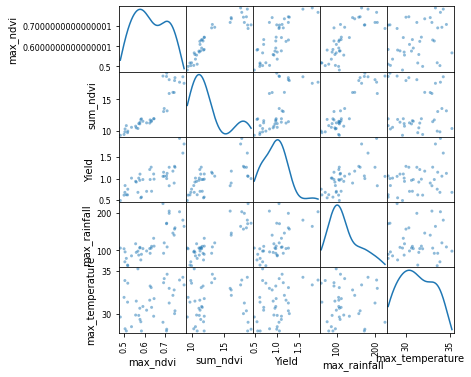

In [26]:
df_train_val_sorghum = crop_scatter_matrix(years_train_validate, 'Sorghum')

Crop: Maize
Pearson corr (linear):
                 max_ndvi  sum_ndvi     Yield  max_rainfall  max_temperature
max_ndvi         1.000000  0.892180  0.420959      0.780750         0.303426
sum_ndvi         0.892180  1.000000  0.263487      0.888051         0.022491
Yield            0.420959  0.263487  1.000000      0.284319         0.291868
max_rainfall     0.780750  0.888051  0.284319      1.000000         0.027430
max_temperature  0.303426  0.022491  0.291868      0.027430         1.000000
Spearman corr (monotonic):
                 max_ndvi  sum_ndvi     Yield  max_rainfall  max_temperature
max_ndvi         1.000000  0.925903  0.666515      0.783440         0.288737
sum_ndvi         0.925903  1.000000  0.572831      0.789615         0.018122
Yield            0.666515  0.572831  1.000000      0.542942         0.373981
max_rainfall     0.783440  0.789615  0.542942      1.000000         0.064386
max_temperature  0.288737  0.018122  0.373981      0.064386         1.000000
Kendal corr:
 

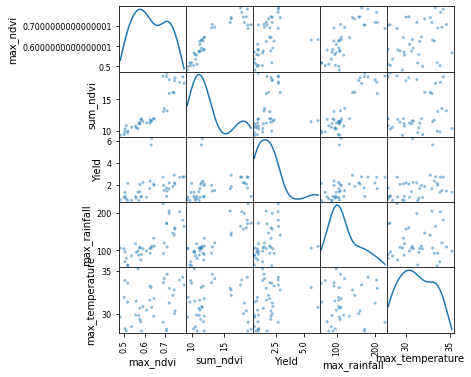

In [27]:
df_train_val_maize = crop_scatter_matrix(years_train_validate, 'Maize', 4)
print(df_train_val_maize.shape)

Maize and sorghum yields seem to have correlation with the max NDVI. Try predicting that yield since it might be easier to train the models

In [28]:
def select_features_from_arrays(df, list_columns=['ndvi_window', 'rainfall_window']):
    #a = [i for i in df['ndvi_fit']]
    #print('selected:')
    #print(a)
    #[i for i in training_set['ndvi_window']]   
    
    
    train_features = []
    
    for x in range(df.shape[0]):
        features = []
        col_0 = df.loc[x,list_columns[0]].copy()  
        if len(list_columns)>1:
            col_1 = df.loc[x,list_columns[1]].copy()
            col_0 = np.concatenate((col_0, col_1), axis=0)
        #print(col_0)
            if len(list_columns)>2:
                col_2 = df.loc[x,list_columns[2]].copy()
                col_0 = np.concatenate((col_0, col_2), axis=0)
        train_features.append(col_0)    
        #print(train_features)

    #(a==train_features).all()    
    return train_features         

In [29]:
df_train_maize = df_train_val_maize.loc[df_train_val_maize['year']<2018]
df_val_maize = df_train_val_maize.loc[df_train_val_maize['year']==2018]
print(df_train_maize.shape)
#print(df_val_maize.shape)
training_size_maize = df_train_maize.shape[0]

df_train_sorghum = df_train_val_sorghum.loc[df_train_val_sorghum['year']<2018]
df_val_sorghum = df_train_val_sorghum.loc[df_train_val_sorghum['year']==2018]
print(df_train_sorghum.shape)
#print(df_val_maize.shape)
training_size_sorghum = df_train_maize.shape[0]

(24, 10)
(26, 10)


In [30]:
df_train_maize = df_train_maize.sample(frac = 1) 
df_train_maize.reset_index(inplace=True)

df_val_maize = df_val_maize.sample(frac = 1) 
df_val_maize.reset_index(inplace=True)

df_train_sorghum = df_train_sorghum.sample(frac = 1) 
df_train_sorghum.reset_index(inplace=True)

df_val_sorghum = df_val_sorghum.sample(frac = 1) 
df_val_sorghum.reset_index(inplace=True)

In [31]:
true_yield_train_maize = df_train_maize.Yield.copy()
train_feat_max_ndvi_maize = df_train_maize['max_ndvi'].copy()

true_yield_val_maize = df_val_maize.Yield.copy()
val_feat_max_ndvi_maize = df_val_maize['max_ndvi'].copy()

# Normalizing the inputs for training, need to add for val/test:
#pre_mean_max_ndvi = np.mean(train_feat_max_ndvi, axis=0)
#train_feat_max_ndvi -= pre_mean_max_ndvi
#pre_std_max_ndvi = np.std(train_feat_max_ndvi, axis=0)
#train_feat_max_ndvi /= pre_std_max_ndvi
#print(np.mean(train_feat_max_ndvi))
#print(np.std(train_feat_max_ndvi))

true_yield_train_sorghum = df_train_sorghum.Yield.copy()
train_feat_max_ndvi_sorghum = df_train_sorghum['max_ndvi'].copy()

true_yield_val_sorghum = df_val_maize.Yield.copy()
val_feat_max_ndvi_sorghum = df_val_maize['max_ndvi'].copy()

In [32]:
from sklearn.linear_model import LinearRegression

In [33]:
def lin_regression(x,y):
    x_array = x.to_numpy().reshape((-1, 1))
    y_array = y.to_numpy()
    reg_model = LinearRegression().fit(x_array, y_array)
    r_sq = reg_model.score(x_array, y_array)
    print("R2: {}".format(r_sq))
    yield_pred = reg_model.predict(x_array)
    return reg_model, x_array, y_array, yield_pred

In [34]:
def evaluate_regression_inc(inp, y_true_array, model, s='Validation set'):
    input_array = inp.copy()
    input_array = inp.to_numpy().reshape((-1, 1))
    reg_pred = model.predict(input_array)
    evaluate_regression(y_true_array, reg_pred, s)
    return reg_pred

In [35]:
def lin_regression_multi(x,y):
    x_array = x
    y_array = y.to_numpy()
    reg_model = LinearRegression().fit(x_array, y_array)
    r_sq = reg_model.score(x_array, y_array)
    print("R2: {}".format(r_sq))
    yield_pred = reg_model.predict(x_array)
    return reg_model, x_array,y_array, yield_pred

In [36]:
def evaluate_regression_inc_multi(inp, y_true_array, model, s='Validation set'):
    input_array = inp.copy()
    reg_pred = model.predict(input_array)
    evaluate_regression(y_true_array, reg_pred, s)
    return reg_pred

R2: 0.5286334053079689
Mean absolute percentage error: 33.85549542153294


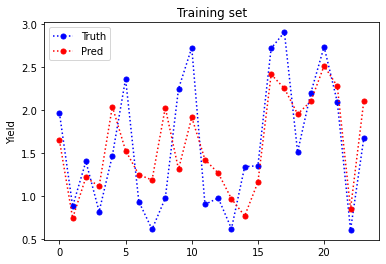

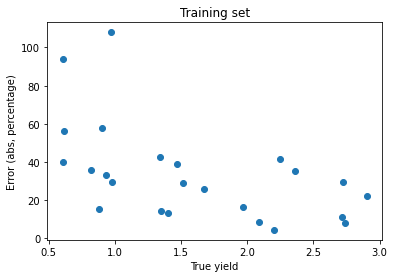

In [37]:
linreg_model_max_ndvi_maize, max_ndvi_array_maize, y_array_maize, linreg_train_max_ndvi_pred_maize = lin_regression(train_feat_max_ndvi_maize, true_yield_train_maize)
evaluate_regression(y_array_maize, linreg_train_max_ndvi_pred_maize)

R2: 0.4950309800912962
Mean absolute percentage error: 18.68002357372293


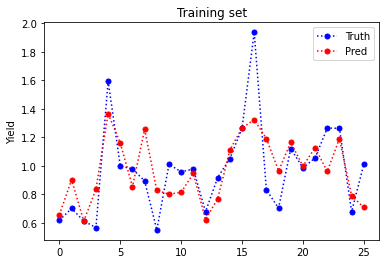

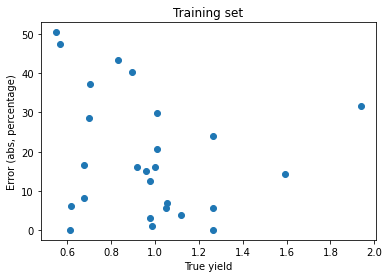

In [38]:
linreg_model_max_ndvi_sorghum,  max_ndvi_array_sorghum, y_array_sorghum, linreg_train_max_ndvi_pred_sorghum = lin_regression(train_feat_max_ndvi_sorghum, true_yield_train_sorghum)
evaluate_regression(y_array_sorghum, linreg_train_max_ndvi_pred_sorghum)

Mean absolute percentage error: 40.0542862997776


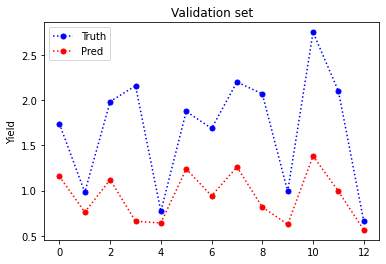

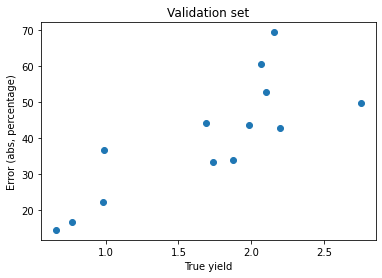

In [39]:
linreg_max_ndvi_val_pred_sorghum = evaluate_regression_inc(val_feat_max_ndvi_sorghum, true_yield_val_sorghum, linreg_model_max_ndvi_sorghum)

In [40]:
train_feat_ndvi_window_sorghum = select_features_from_arrays(df_train_sorghum, ['ndvi_window'])
val_feat_ndvi_window_sorghum = select_features_from_arrays(df_val_sorghum, ['ndvi_window'])

R2: 0.530075683183989
Mean absolute percentage error: 17.763676539842642


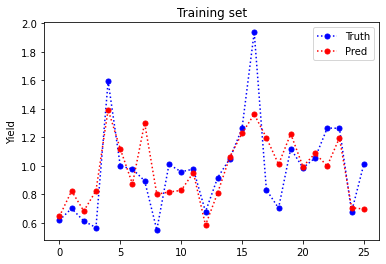

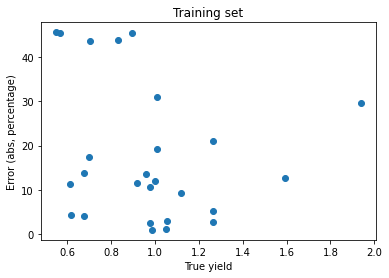

In [41]:
linreg_model_ndvi_window_sorghum, ndvi_window_array_sorghum, y_array_sorghum, linreg_train_ndvi_window_pred_sorghum = lin_regression_multi(train_feat_ndvi_window_sorghum, true_yield_train_sorghum)
evaluate_regression(y_array_sorghum, linreg_train_ndvi_window_pred_sorghum)

Mean absolute percentage error: 53.99060247670688


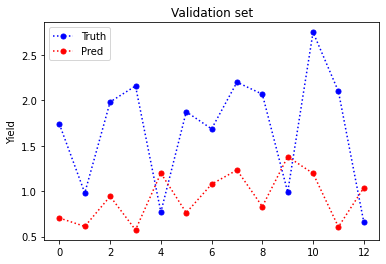

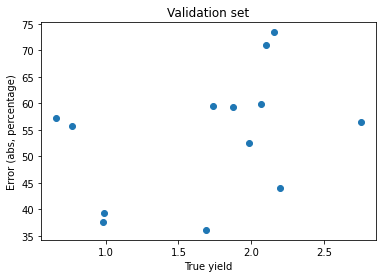

In [42]:
linreg_val_ndvi_window_pred_sorghum = evaluate_regression_inc_multi(val_feat_ndvi_window_sorghum, true_yield_val_sorghum, linreg_model_ndvi_window_sorghum)

In [43]:
def prepare_test_set(years_test = years_test, crop='Sorghum'):
    df_test = crop_scatter_matrix(years_test, crop)
    df_test.reset_index(inplace=True)
    test_feat_ndvi_window = select_features_from_arrays(df_test, ['ndvi_window'])
    return df_test, test_feat_ndvi_window

Crop: Sorghum
Pearson corr (linear):
                 max_ndvi  sum_ndvi     Yield  max_rainfall  max_temperature
max_ndvi         1.000000  0.916664  0.642463      0.792640         0.411340
sum_ndvi         0.916664  1.000000  0.419270      0.858452         0.212628
Yield            0.642463  0.419270  1.000000      0.512022         0.555730
max_rainfall     0.792640  0.858452  0.512022      1.000000         0.061770
max_temperature  0.411340  0.212628  0.555730      0.061770         1.000000
Spearman corr (monotonic):
                 max_ndvi  sum_ndvi     Yield  max_rainfall  max_temperature
max_ndvi         1.000000  0.895105  0.713287      0.769231         0.349650
sum_ndvi         0.895105  1.000000  0.503497      0.874126         0.076923
Yield            0.713287  0.503497  1.000000      0.503497         0.510490
max_rainfall     0.769231  0.874126  0.503497      1.000000        -0.034965
max_temperature  0.349650  0.076923  0.510490     -0.034965         1.000000
Kendal corr:

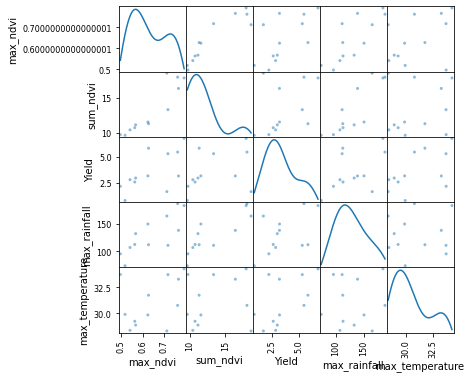

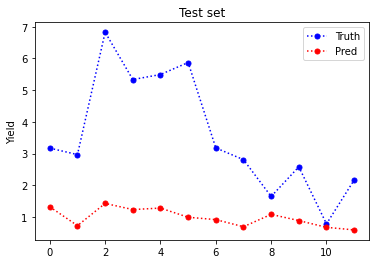

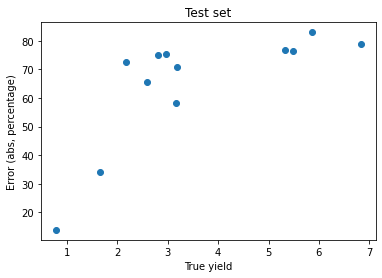

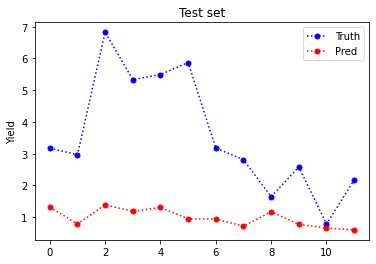

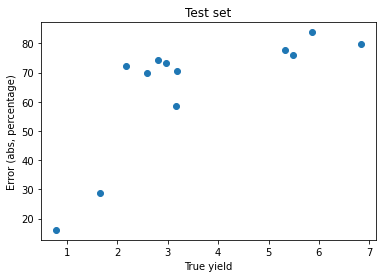

In [44]:
df_test_sorghum, test_feat_ndvi_window_sorghum = prepare_test_set()
linreg_test_ndvi_window_pred_sorghum = linreg_model_ndvi_window_sorghum.predict(test_feat_ndvi_window_sorghum)
evaluate_regression(df_test_sorghum.Yield, linreg_test_ndvi_window_pred_sorghum, 'Test set')
linreg_test_max_ndvi_pred_sorghum = evaluate_regression_inc(df_test_sorghum.max_ndvi, df_test_sorghum.Yield, linreg_model_max_ndvi_sorghum, s='Test set')

In [45]:
# For now assume the ndvi window 
def annual_predictions_val_test(df_val, val_pred, df_test, test_pred, fig_name='linear_ndvi_window_val_test_sorghum', save_df=False):
    df_val_pred = df_val_sorghum.copy()
    
    df_val_pred['Pred_2018'] = val_pred
    df_val_pred = df_val_pred.rename(columns={"Yield": "Yield_2018"})
    df_val_pred = df_val_pred.set_index('region_name')
    df_val_pred = df_val_pred[['Yield_2018','Pred_2018']]
    plt.figure()  
    df_val_pred.plot.bar(figsize=(40, 10))
    plt.title('True and and Predicted Yields for 2018', fontsize=24)
    plt.savefig('timeseries_outputs/'+fig_name+'_val.png')
    print(df_val_pred)

    if save_df:
        df_val_pred.to_csv('timeseries_outputs/'+fig_name+'_df_2018.csv')        
    
    val_abs_per_err = np.abs(df_val_pred['Pred_2018'] - df_val_pred['Yield_2018'])/df_val_pred['Yield_2018'] * 100 
    plt.figure()  
    val_abs_per_err.plot.bar(figsize=(40, 10))
    plt.title('Absolute Percentage Error for 2018 (True and Predicted Yields)', fontsize=24)
    plt.savefig(fig_name+'_val_err.png')
    
    df_test_pred = df_test.copy()
    df_test_pred['Pred_2019'] = test_pred
    df_test_pred = df_test_pred.rename(columns={"Yield": "Yield_2019"})
    df_test_pred = df_test_pred.set_index('region_name')
    df_test_pred = df_test_pred[['Yield_2019','Pred_2019']]   
    plt.figure()  
    df_test_pred.plot.bar(figsize=(40, 10))
    plt.title('True and Predicted Yields for 2019', fontsize=24)
    plt.savefig('timeseries_outputs/'+fig_name+'_test.png')
    
    if save_df:
        df_test_pred.to_csv('timeseries_outputs/'+fig_name+'_df_2019.csv')        
    
    #test_abs_per_err = np.abs(df_test_pred['Pred_2019'] - df_test_pred['Yield_2019'])/df_test_pred['Yield_2019'] * 100    
    #plt.figure()  
    #test_abs_per_err.plot.bar(figsize=(40, 10), title='Abs per errors for 2019')

    plt.figure()  
    df_test_pred = df_val_pred.merge(df_test_pred, how='outer', on=['region_name'])
    df_test_pred.plot.bar(figsize=(40, 10))
    plt.title('True and Predicted Yields for 2018 and 2019', fontsize=24)
    plt.savefig('timeseries_outputs/'+fig_name+'_val_test.png')

             Yield_2018  Pred_2018
region_name                       
MATAM            0.7513   0.704752
LOUGA            0.4873   0.612106
KAFFRINE         1.2100   0.943550
THIES            0.8360   0.573660
SEDHIOU          1.2848   1.198745
DIOURBEL         0.9339   0.762461
ZIGUINCHOR       1.0604   1.077516
KOLDA            1.1726   1.232930
FATICK           1.1033   0.831043
KEDOUGOU         1.8062   1.379575
TAMBACOUNDA      1.1473   1.195961
DAKAR            0.6215   0.606957
KAOLACK          1.1055   1.037629


<Figure size 432x288 with 0 Axes>

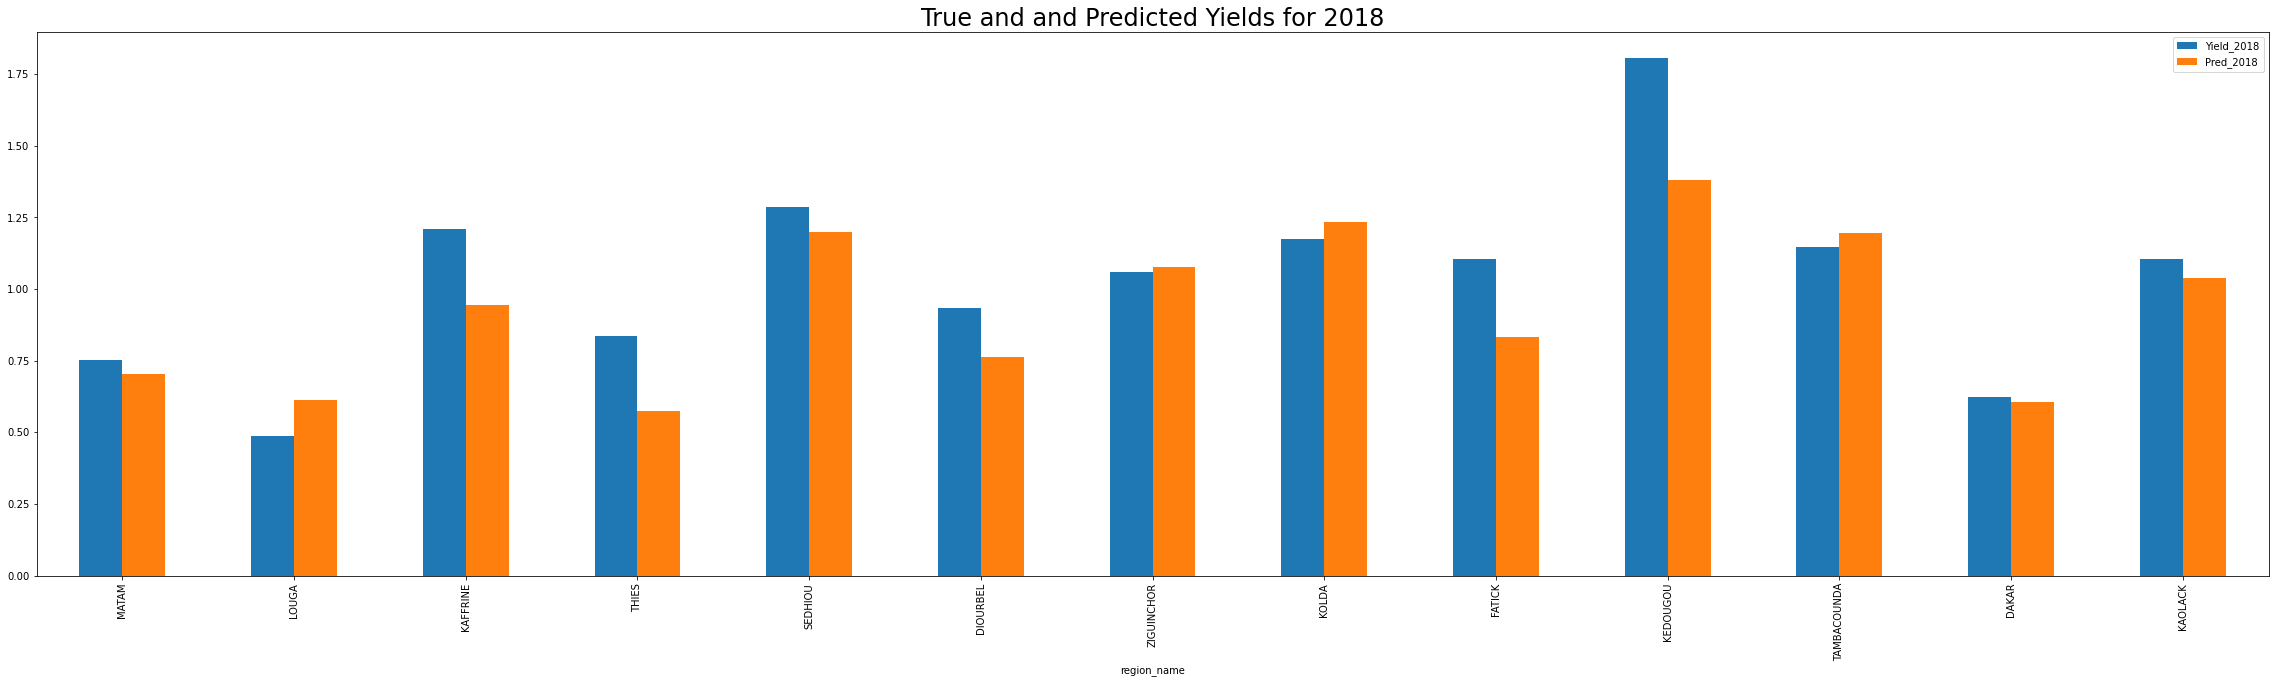

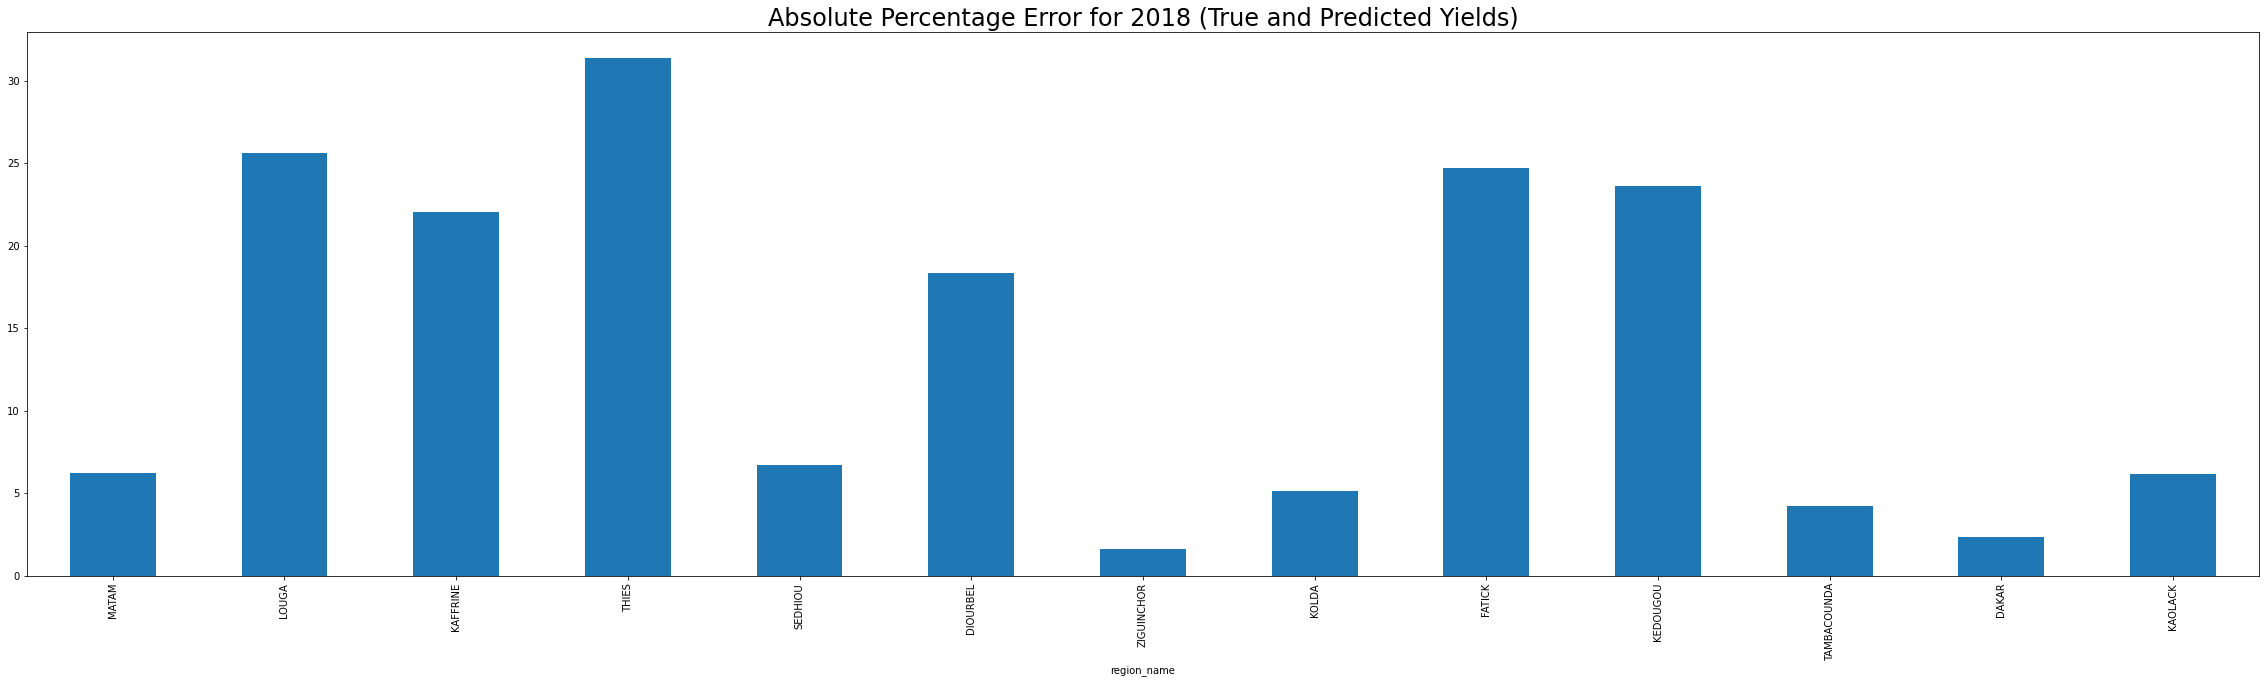

<Figure size 432x288 with 0 Axes>

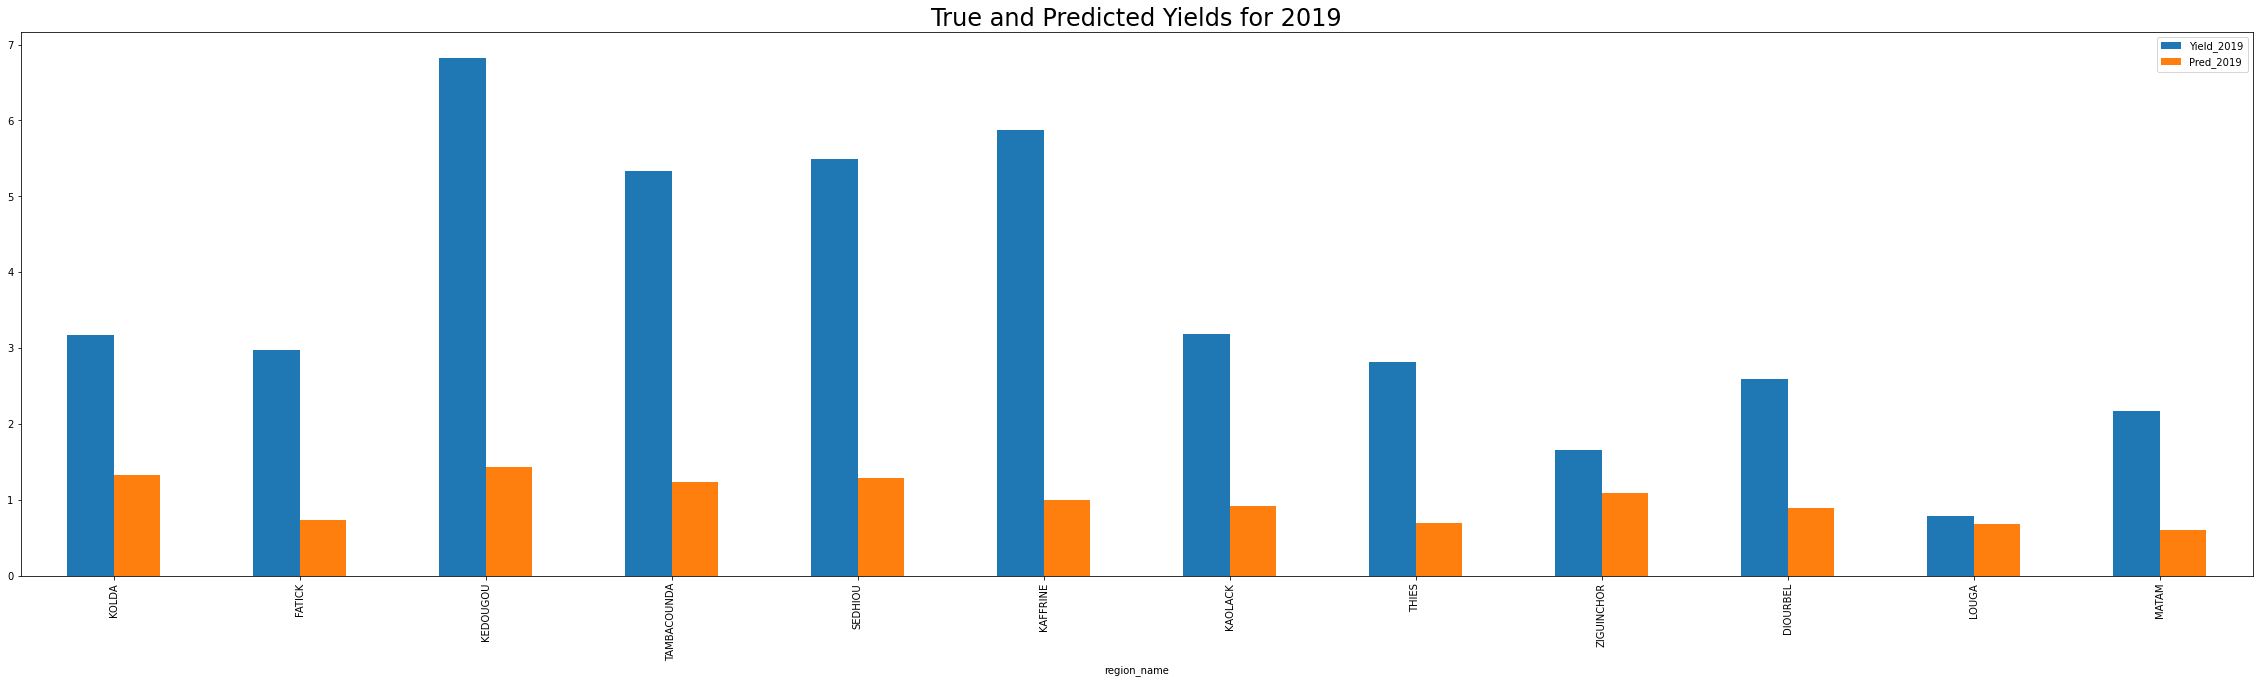

<Figure size 432x288 with 0 Axes>

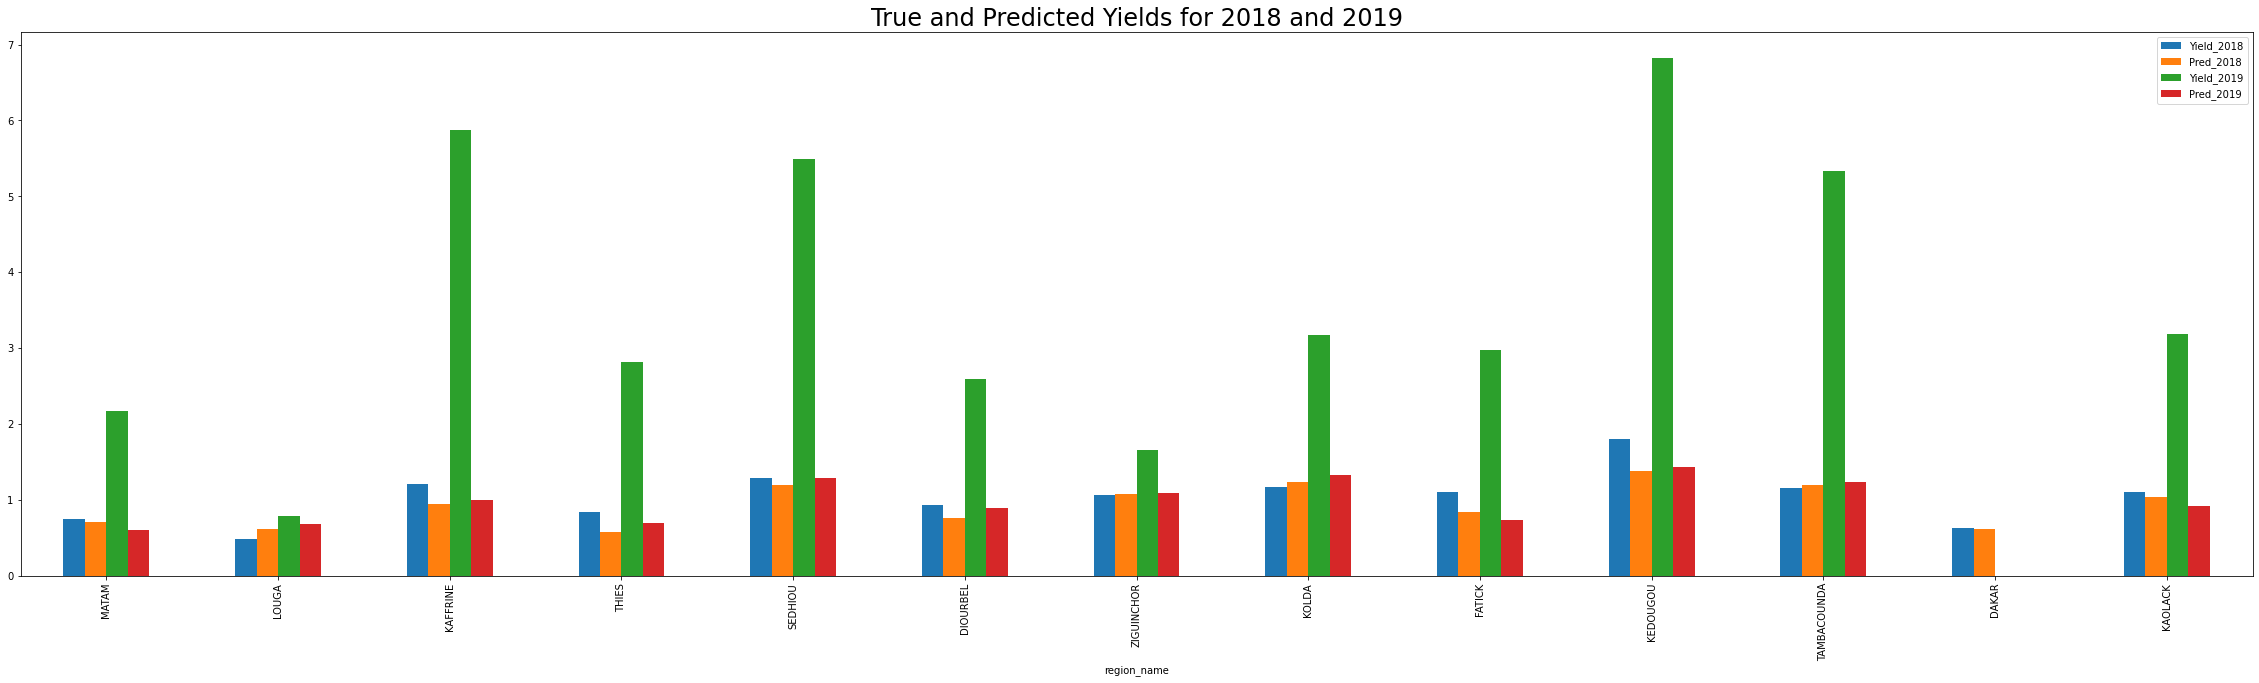

In [46]:
annual_predictions_val_test(df_val_sorghum, linreg_val_ndvi_window_pred_sorghum, df_test_sorghum, linreg_test_ndvi_window_pred_sorghum, save_df=True)

             Yield_2018  Pred_2018
region_name                       
MATAM            0.7513   1.156435
LOUGA            0.4873   0.760769
KAFFRINE         1.2100   1.119258
THIES            0.8360   0.659861
SEDHIOU          1.2848   0.641273
DIOURBEL         0.9339   1.238754
ZIGUINCHOR       1.0604   0.941341
KOLDA            1.1726   1.259998
FATICK           1.1033   0.816534
KEDOUGOU         1.8062   0.625340
TAMBACOUNDA      1.1473   1.382150
DAKAR            0.6215   0.991795
KAOLACK          1.1055   0.564264


<Figure size 432x288 with 0 Axes>

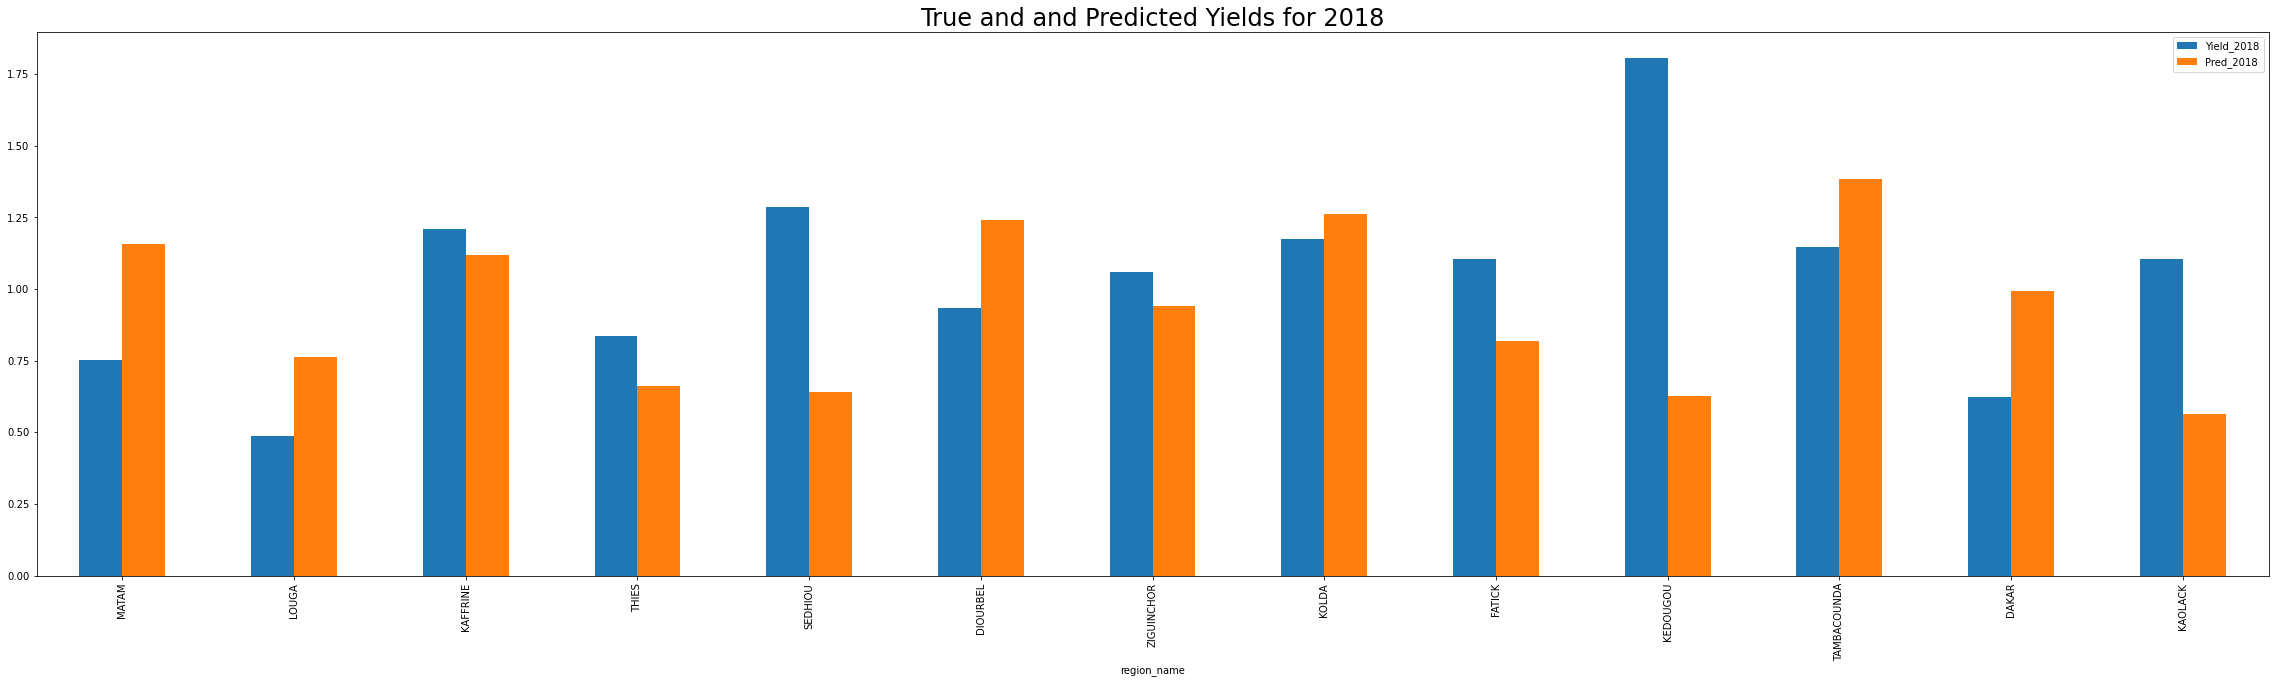

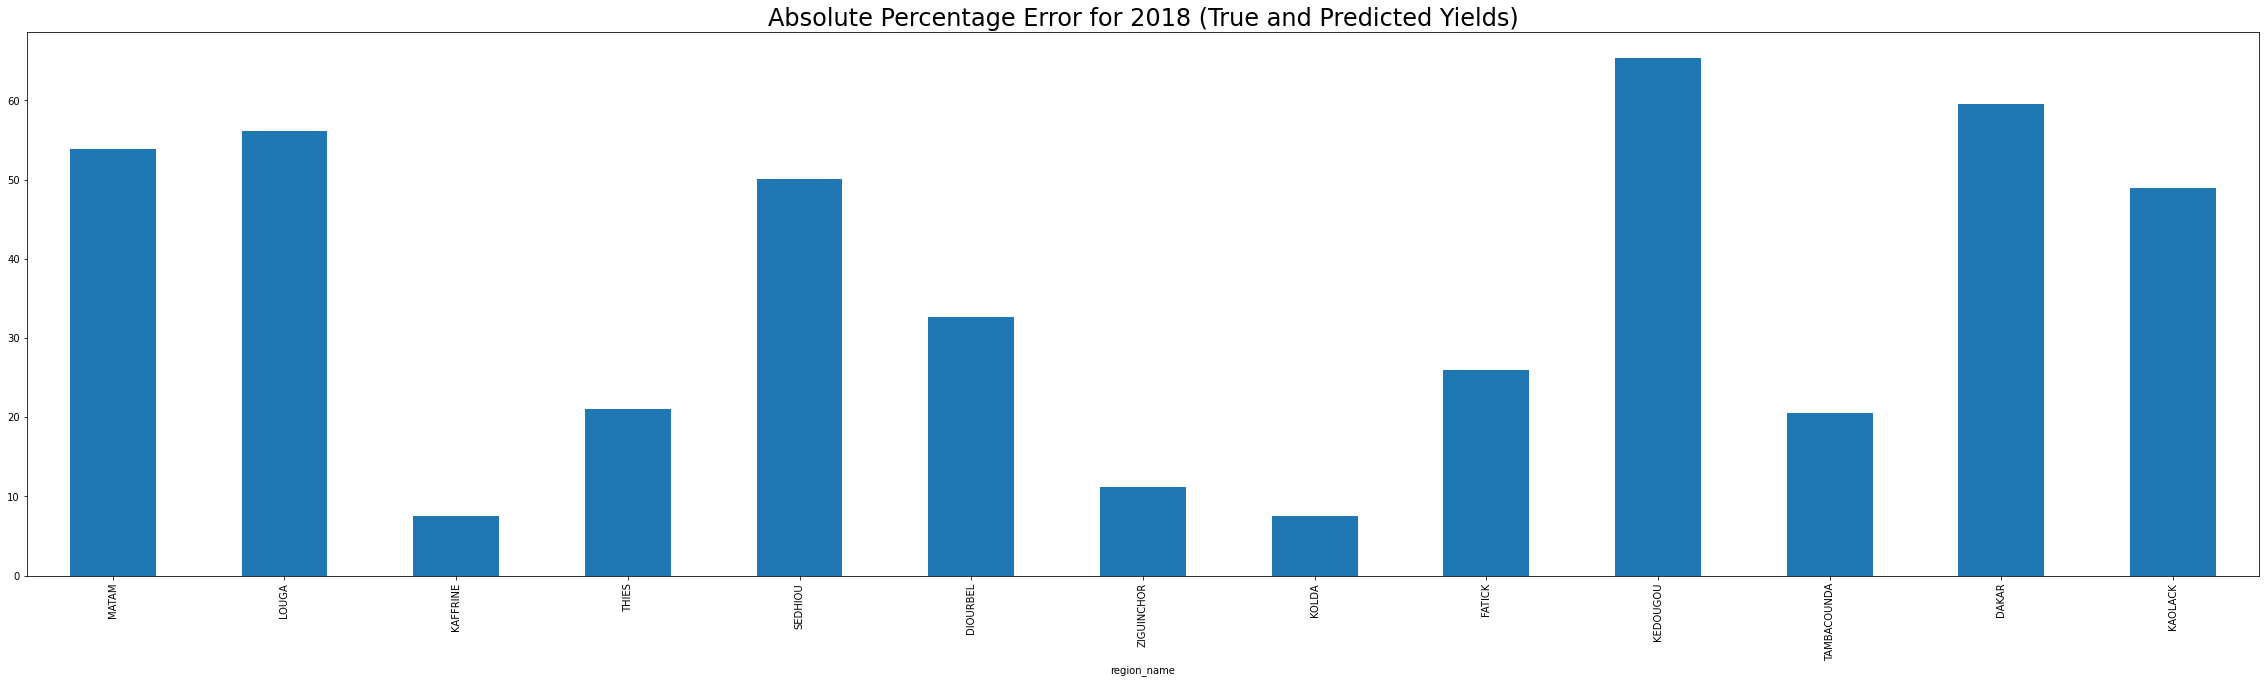

<Figure size 432x288 with 0 Axes>

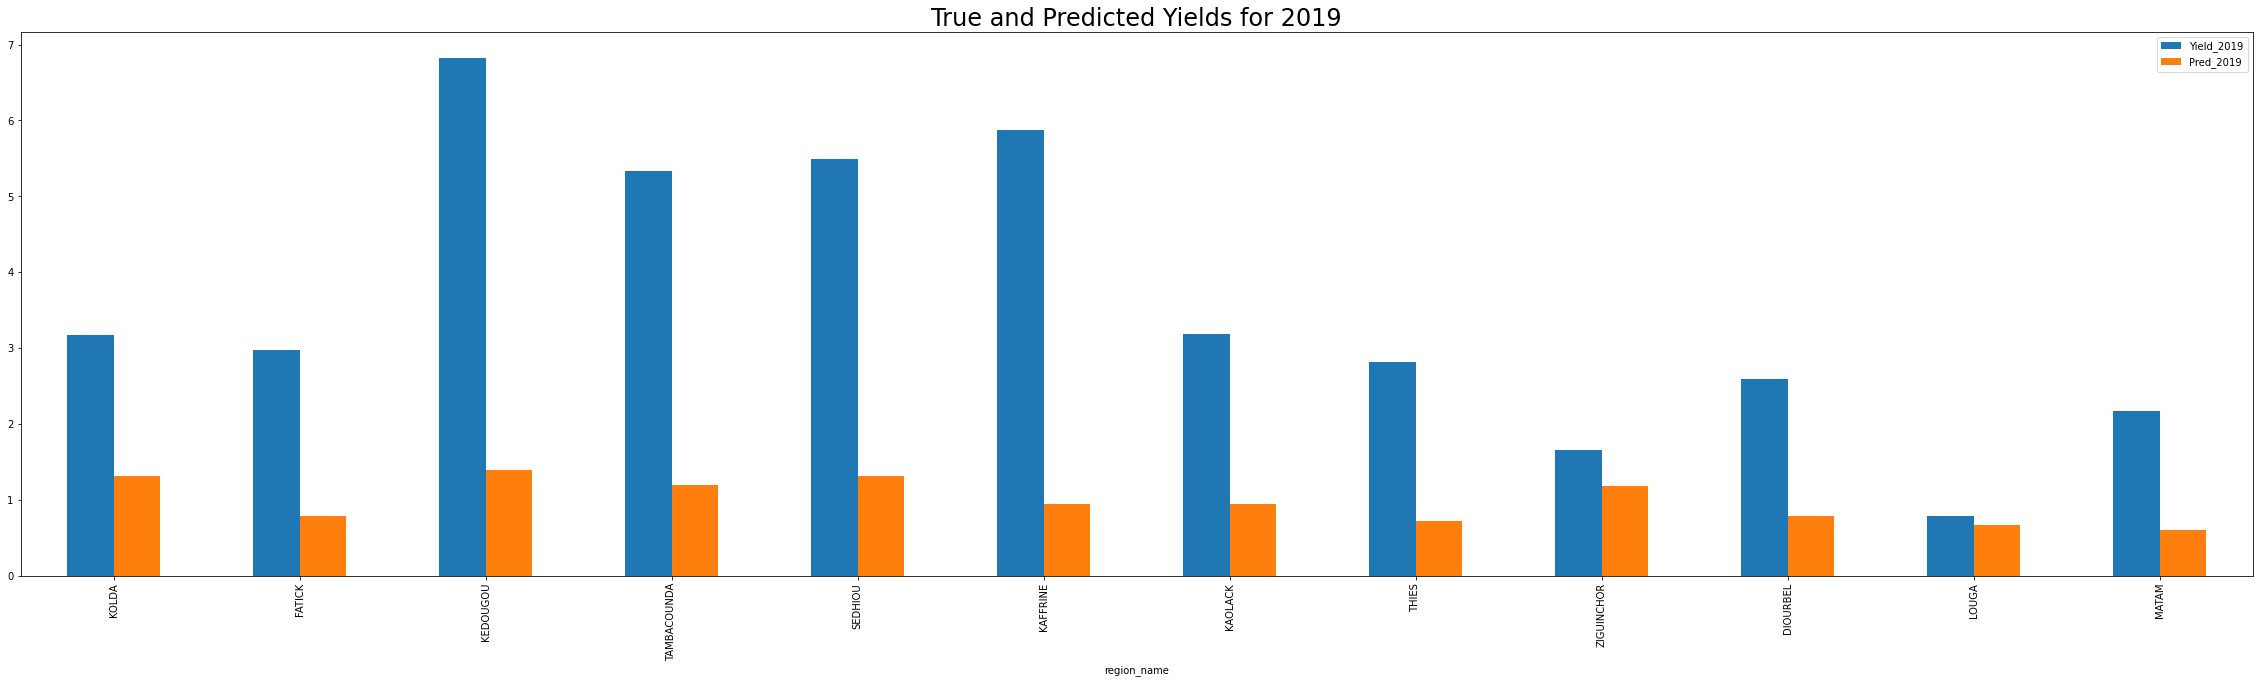

<Figure size 432x288 with 0 Axes>

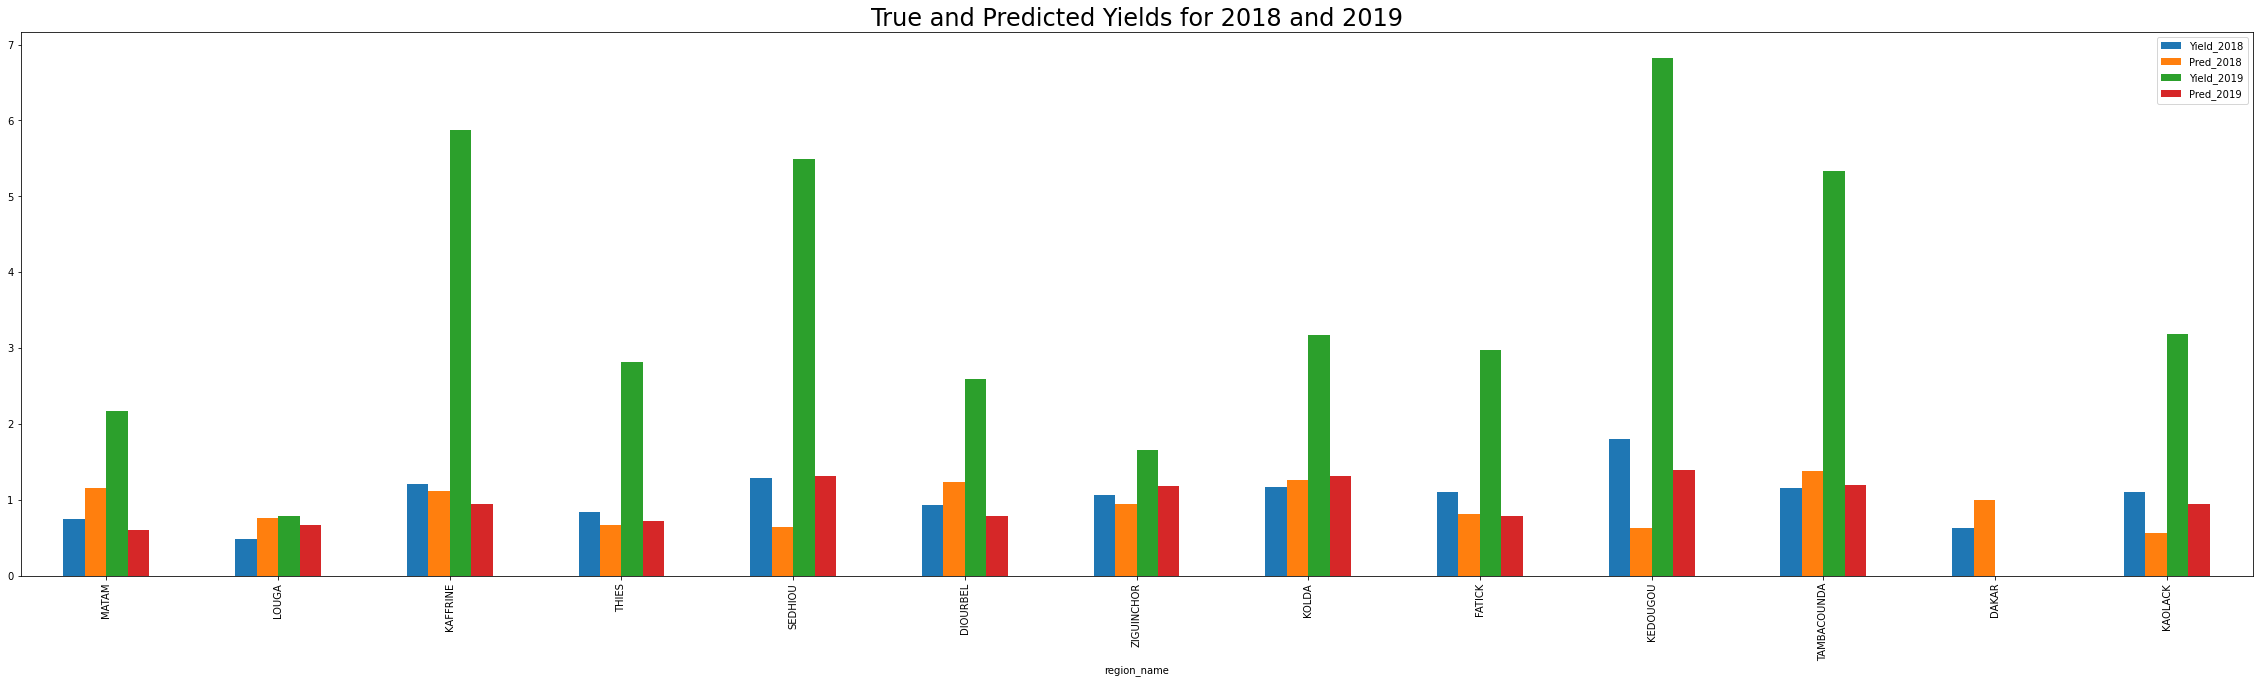

In [47]:
annual_predictions_val_test(df_val_sorghum, linreg_max_ndvi_val_pred_sorghum, df_test_sorghum, linreg_test_max_ndvi_pred_sorghum, fig_name='linear_max_ndvi_val_test_sorghum', save_df=True)

In [48]:
# Use the NDVI window with a more advanced regressor?

In [49]:
def annual_predictions_val_test_years(df_val, val_pred, df_train, fig_name='linear_ndvi_window_years_sorghum'):
    df_val_pred = df_val_sorghum.copy()
    
    df_val_pred['Pred_2018'] = val_pred
    df_val_pred = df_val_pred.rename(columns={"Yield": "Yield_2018"})
    df_val_pred = df_val_pred[['Yield_2018','Pred_2018', 'region_name']]
    df_val_pred = df_val_pred.set_index('region_name')
    #plt.figure()  
    #df_val_pred.plot.bar(figsize=(40, 10), title='Predictions and Real Yields for 2018')
    
    
    df_train_new = df_train.copy()
    #df_train_2017 = df_train.copy()
    
    df_train_2016 = df_train_new.loc[df_train['year']==2016 ,['Yield', 'region_name']]
    df_train_2017 = df_train_new.loc[df_train['year']==2017 ,['Yield', 'region_name']]
    df_train_2016 = df_train_2016.rename(columns={"Yield": "Yield_2016"})
    df_train_2017 = df_train_2017.rename(columns={"Yield": "Yield_2017"})
    
    df_train_2016_2017 = df_train_2016.merge(df_train_2017, how = 'left', on=['region_name'])
    df_train_2016_2017 = df_train_2016_2017.set_index('region_name')
    print(df_train_2016_2017)
    
    
    #plt.figure()  
    #df_train_2016_2017.plot.bar(figsize=(40, 10), title='Trainingset')
    plt.figure()
    df_train_merged = df_train_2016_2017.merge(df_val_pred, how='left', on=['region_name'])
    df_train_merged.plot.bar(figsize=(40, 10))
    plt.title('True Yields for Consecutive Years and Predicted Yield for 2018', fontsize=24)
    plt.savefig('timeseries_outputs/'+fig_name+'.png')


             Yield_2016  Yield_2017
region_name                        
KOLDA            0.8943      0.8316
FATICK           0.9581      0.9768
DAKAR            0.5665      0.5500
KEDOUGOU         1.5939      1.9371
TAMBACOUNDA      1.1209      1.0549
SEDHIOU          1.2628      1.2628
KAFFRINE         1.2650      0.9768
KAOLACK          0.7029      0.9856
THIES            1.0098      1.0098
ZIGUINCHOR       0.9988      1.0505
DIOURBEL         0.9174      0.7007
LOUGA            0.6127      0.6182
MATAM            0.6776      0.6776


<Figure size 432x288 with 0 Axes>

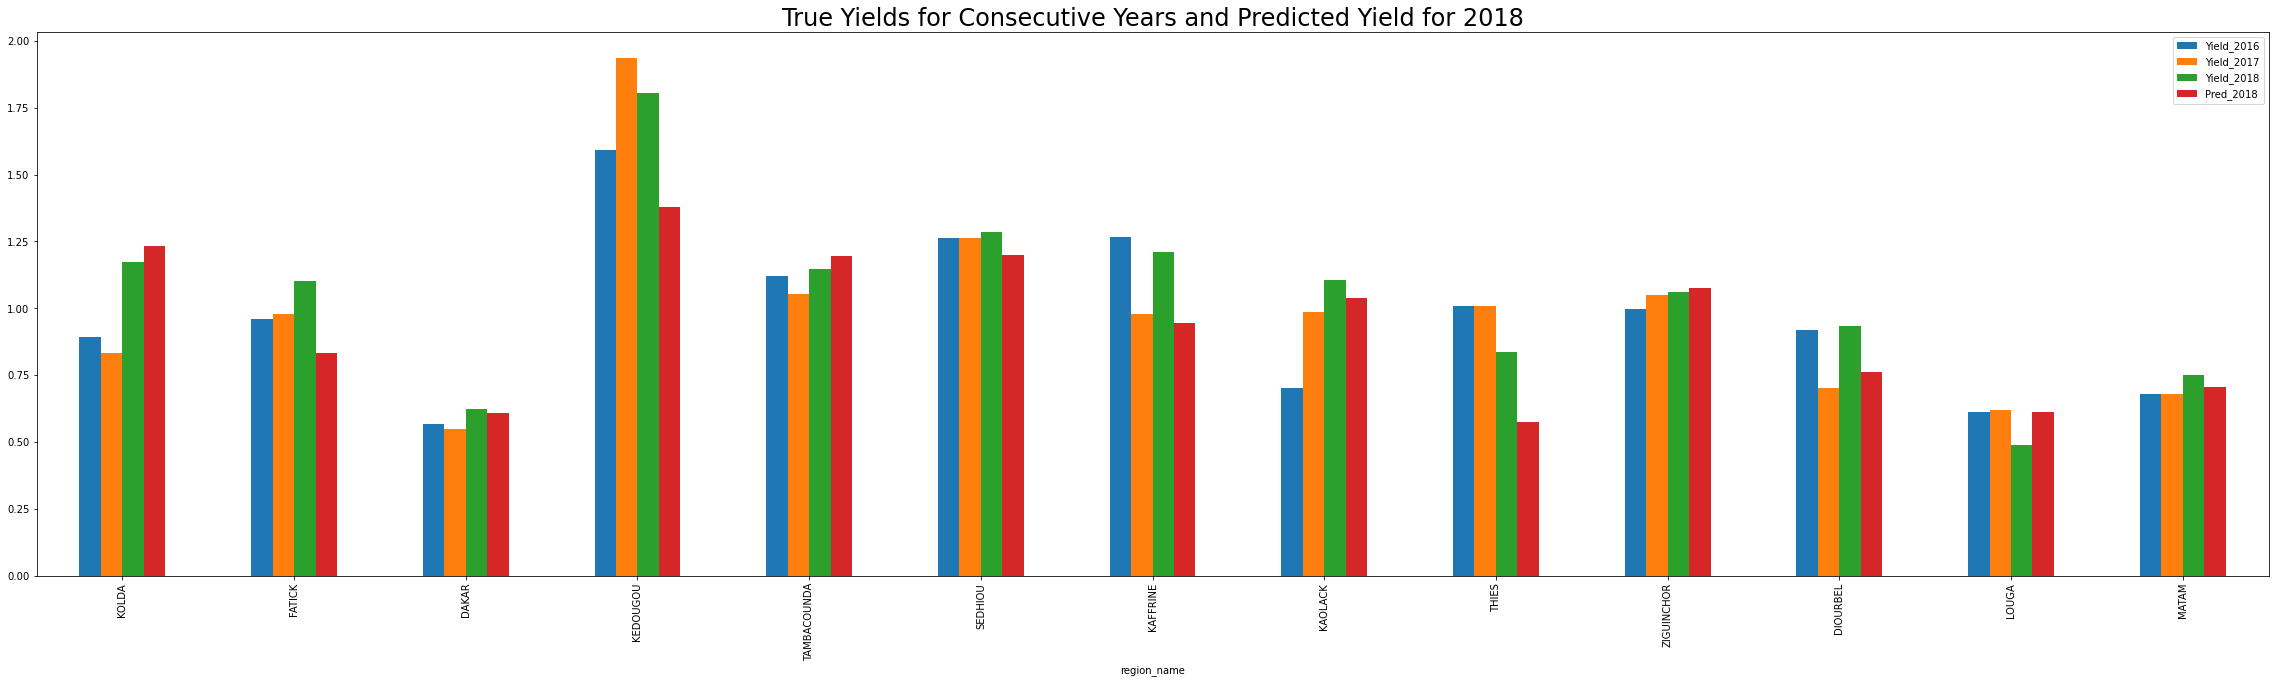

In [50]:
annual_predictions_val_test_years(df_val_sorghum, linreg_val_ndvi_window_pred_sorghum, df_train_val_sorghum)

Out of 13, 7 predictions imply the behaviour of the yield compared to the previous 2 years (used for training)

In [51]:
df_val_sorghum_copy = df_val_sorghum.loc[df_val_sorghum['region_name']=='KAFFRINE','ndvi_window'].to_numpy()
print(df_val_sorghum_copy)

[array([0.575, 0.614, 0.624, 0.601, 0.548, 0.474])]


In [52]:
# For serialization:
import joblib
import pickle

In [53]:
with open('timeseries_models/linreg_model_ndvi_window_sorghum.pkl', 'wb') as pkl:
    pickle.dump(linreg_model_ndvi_window_sorghum, pkl, -1)    

In [54]:
with open('timeseries_models/linreg_model_max_ndvi_sorghum.pkl', 'wb') as pkl:
    pickle.dump(linreg_model_max_ndvi_sorghum, pkl, -1)    

R2: 0.6366711254523314
Mean absolute percentage error: 27.71948492936231
Mean absolute percentage error: 30.165865282403537


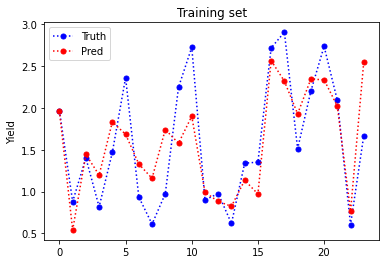

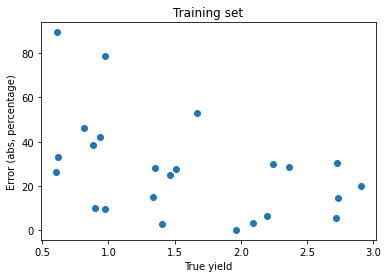

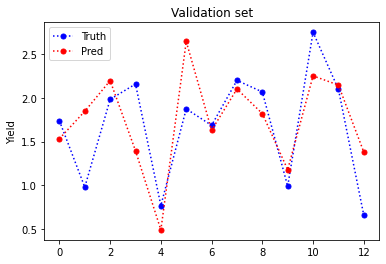

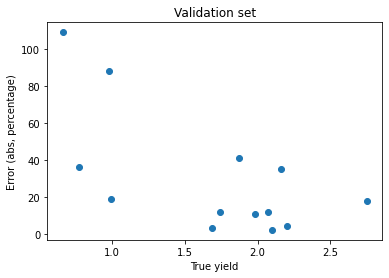

In [55]:
train_feat_ndvi_window_maize = select_features_from_arrays(df_train_maize, ['ndvi_window'])
val_feat_ndvi_window_maize = select_features_from_arrays(df_val_maize, ['ndvi_window'])

linreg_model_ndvi_window_maize, ndvi_window_array_maize, y_array_maize, linreg_train_ndvi_window_pred_maize = lin_regression_multi(train_feat_ndvi_window_maize, true_yield_train_maize)
evaluate_regression(y_array_maize, linreg_train_ndvi_window_pred_maize)

linreg_val_ndvi_window_pred_maize = evaluate_regression_inc_multi(val_feat_ndvi_window_maize, true_yield_val_maize, linreg_model_ndvi_window_maize)


Crop: Maize
Pearson corr (linear):
                 max_ndvi  sum_ndvi     Yield  max_rainfall  max_temperature
max_ndvi         1.000000  0.918119  0.797014      0.796328         0.427117
sum_ndvi         0.918119  1.000000  0.660434      0.861228         0.246823
Yield            0.797014  0.660434  1.000000      0.701009         0.516983
max_rainfall     0.796328  0.861228  0.701009      1.000000         0.123260
max_temperature  0.427117  0.246823  0.516983      0.123260         1.000000
Spearman corr (monotonic):
                 max_ndvi  sum_ndvi     Yield  max_rainfall  max_temperature
max_ndvi         1.000000  0.906593  0.835165      0.780220         0.346154
sum_ndvi         0.906593  1.000000  0.642857      0.851648         0.087912
Yield            0.835165  0.642857  1.000000      0.642857         0.571429
max_rainfall     0.780220  0.851648  0.642857      1.000000         0.082418
max_temperature  0.346154  0.087912  0.571429      0.082418         1.000000
Kendal corr:
 

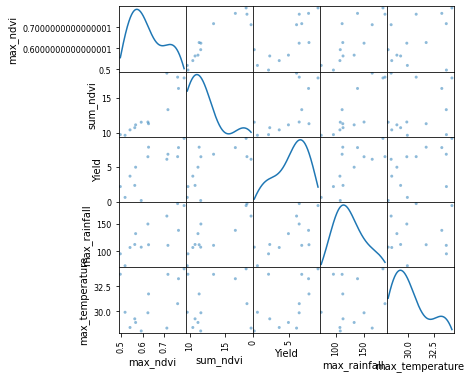

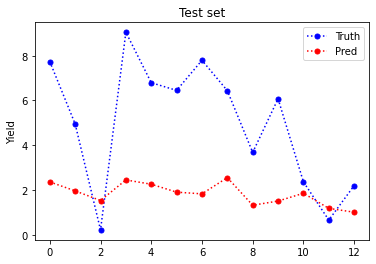

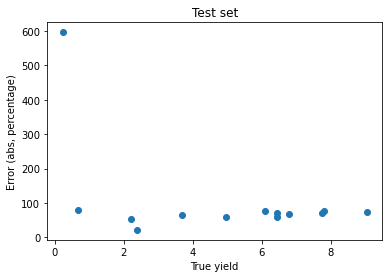

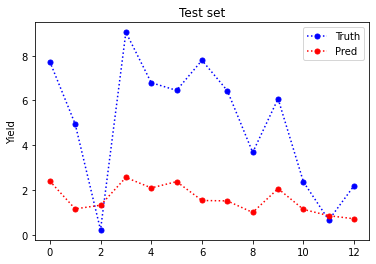

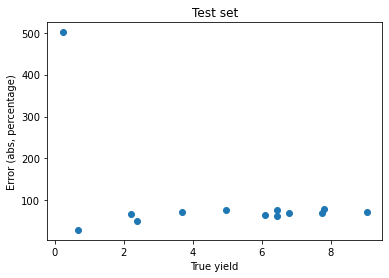

In [56]:
df_test_maize, test_feat_ndvi_window_maize = prepare_test_set(years_test,'Maize')
linreg_test_ndvi_window_pred_maize = linreg_model_ndvi_window_maize.predict(test_feat_ndvi_window_maize)
evaluate_regression(df_test_maize.Yield, linreg_test_ndvi_window_pred_maize, 'Test set')
linreg_test_max_ndvi_pred_maize = evaluate_regression_inc(df_test_maize.max_ndvi, df_test_maize.Yield, linreg_model_max_ndvi_maize, s='Test set')

Crop: Maize
Pearson corr (linear):
                 max_ndvi  sum_ndvi     Yield  max_rainfall  max_temperature
max_ndvi         1.000000  0.918119  0.797014      0.796328         0.427117
sum_ndvi         0.918119  1.000000  0.660434      0.861228         0.246823
Yield            0.797014  0.660434  1.000000      0.701009         0.516983
max_rainfall     0.796328  0.861228  0.701009      1.000000         0.123260
max_temperature  0.427117  0.246823  0.516983      0.123260         1.000000
Spearman corr (monotonic):
                 max_ndvi  sum_ndvi     Yield  max_rainfall  max_temperature
max_ndvi         1.000000  0.906593  0.835165      0.780220         0.346154
sum_ndvi         0.906593  1.000000  0.642857      0.851648         0.087912
Yield            0.835165  0.642857  1.000000      0.642857         0.571429
max_rainfall     0.780220  0.851648  0.642857      1.000000         0.082418
max_temperature  0.346154  0.087912  0.571429      0.082418         1.000000
Kendal corr:
 

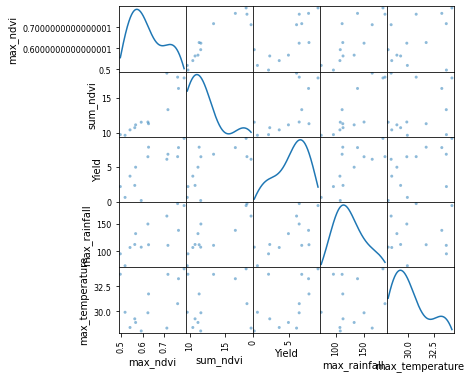

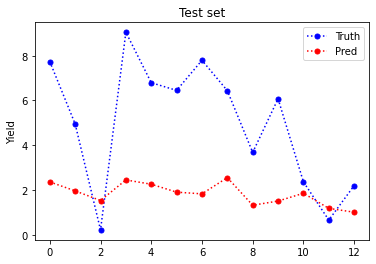

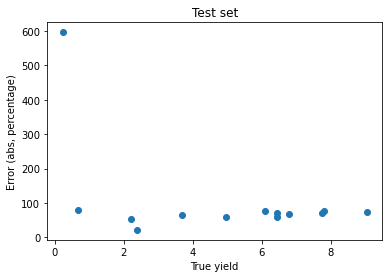

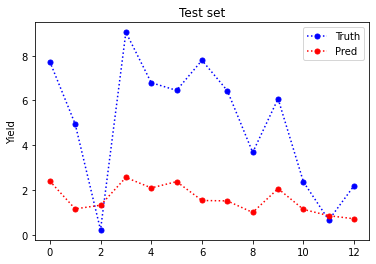

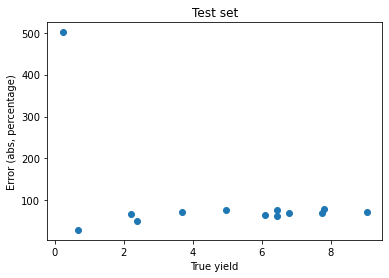

In [57]:
df_test_maize, test_feat_ndvi_window_maize = prepare_test_set(years_test,crop='Maize')
linreg_test_ndvi_window_pred_maize = linreg_model_ndvi_window_maize.predict(test_feat_ndvi_window_maize)
evaluate_regression(df_test_maize.Yield, linreg_test_ndvi_window_pred_maize, 'Test set')
linreg_test_max_ndvi_pred_maize = evaluate_regression_inc(df_test_maize.max_ndvi, df_test_maize.Yield, linreg_model_max_ndvi_maize, s='Test set')

             Yield_2018  Pred_2018
region_name                       
MATAM            0.7513   1.533516
LOUGA            0.4873   1.847069
KAFFRINE         1.2100   2.196893
THIES            0.8360   1.395603
SEDHIOU          1.2848   0.491490
DIOURBEL         0.9339   2.644462
ZIGUINCHOR       1.0604   1.630539
KOLDA            1.1726   2.101567
FATICK           1.1033   1.820848
KEDOUGOU         1.8062   1.179705
TAMBACOUNDA      1.1473   2.251812
DAKAR            0.6215   2.146398
KAOLACK          1.1055   1.381365


<Figure size 432x288 with 0 Axes>

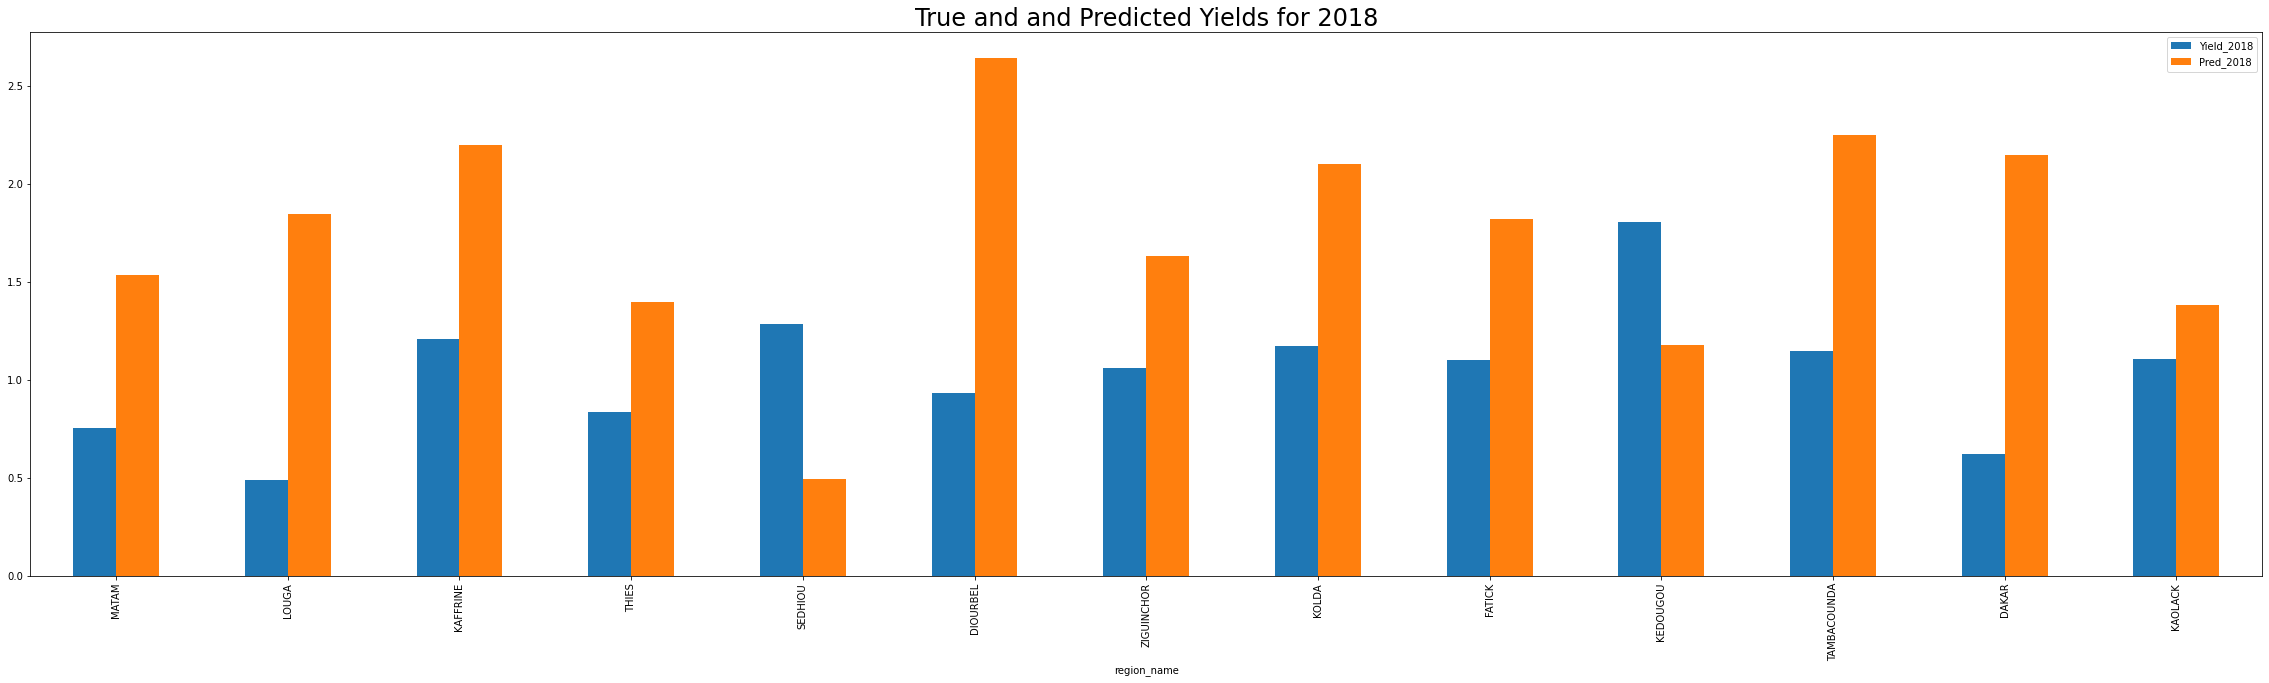

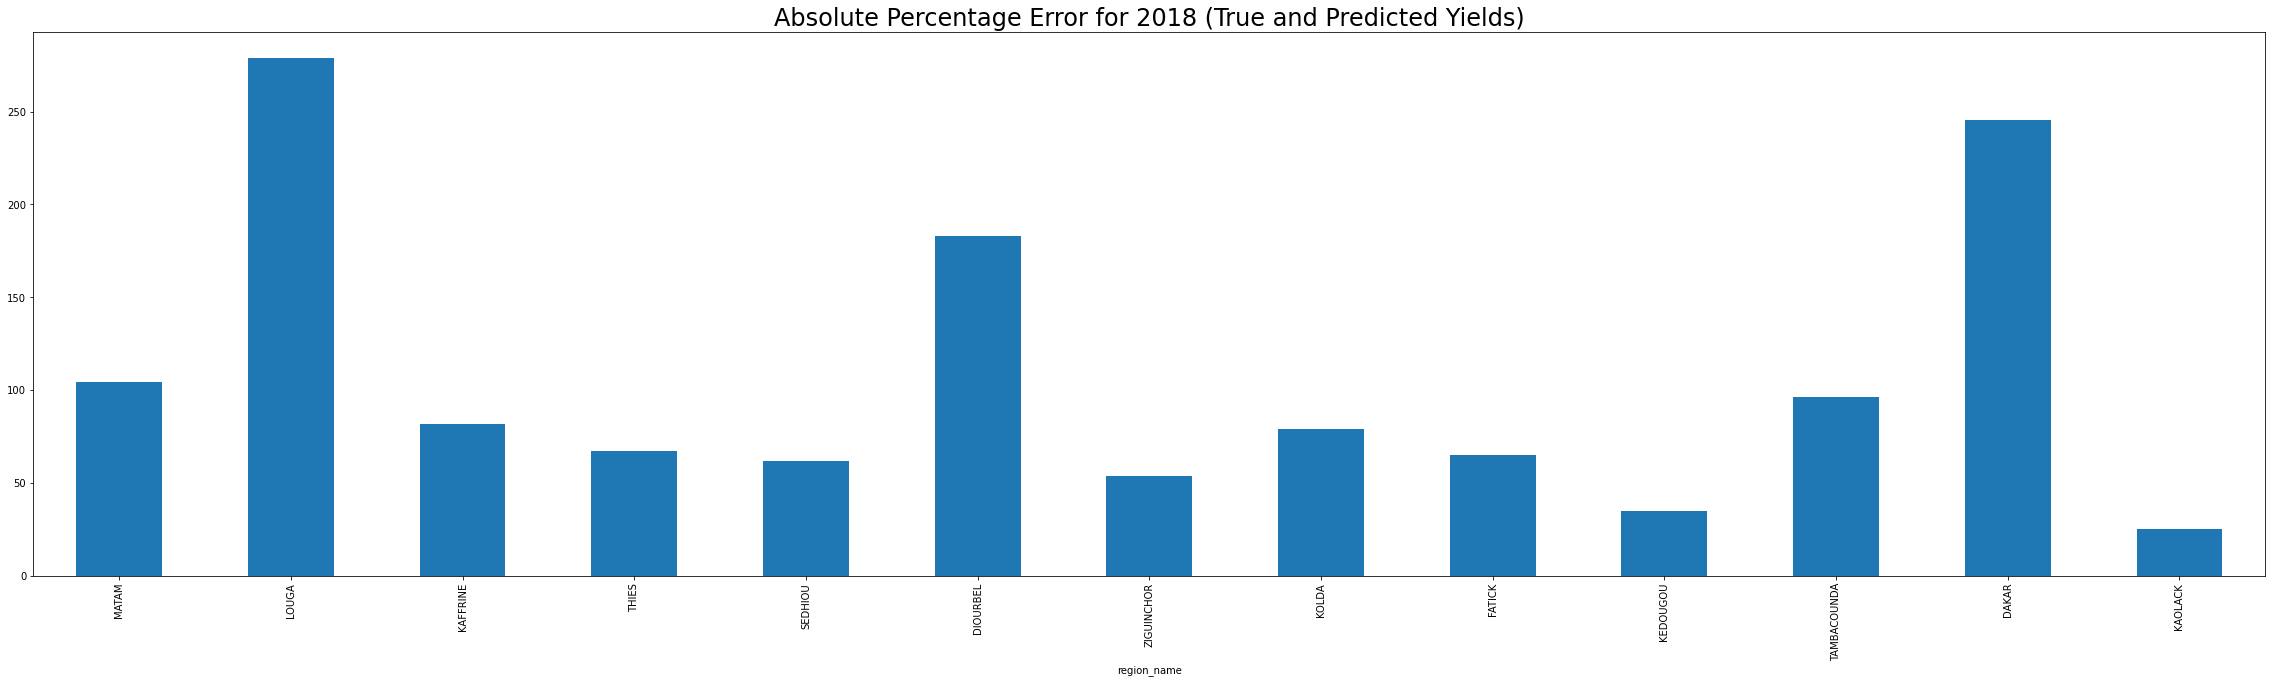

<Figure size 432x288 with 0 Axes>

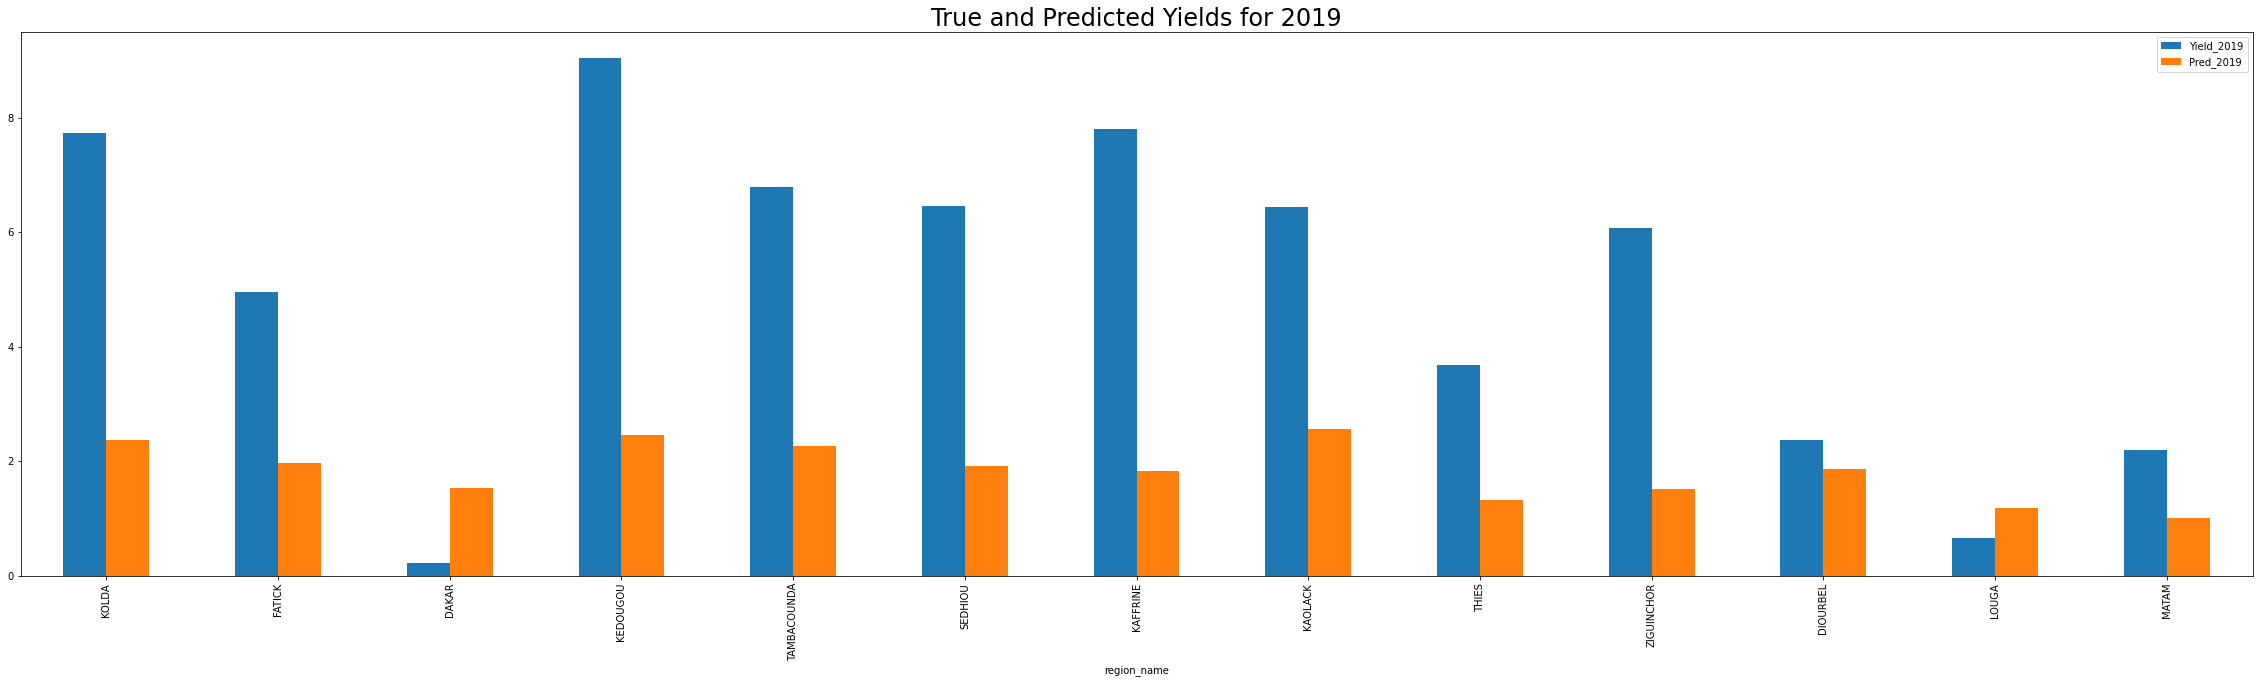

<Figure size 432x288 with 0 Axes>

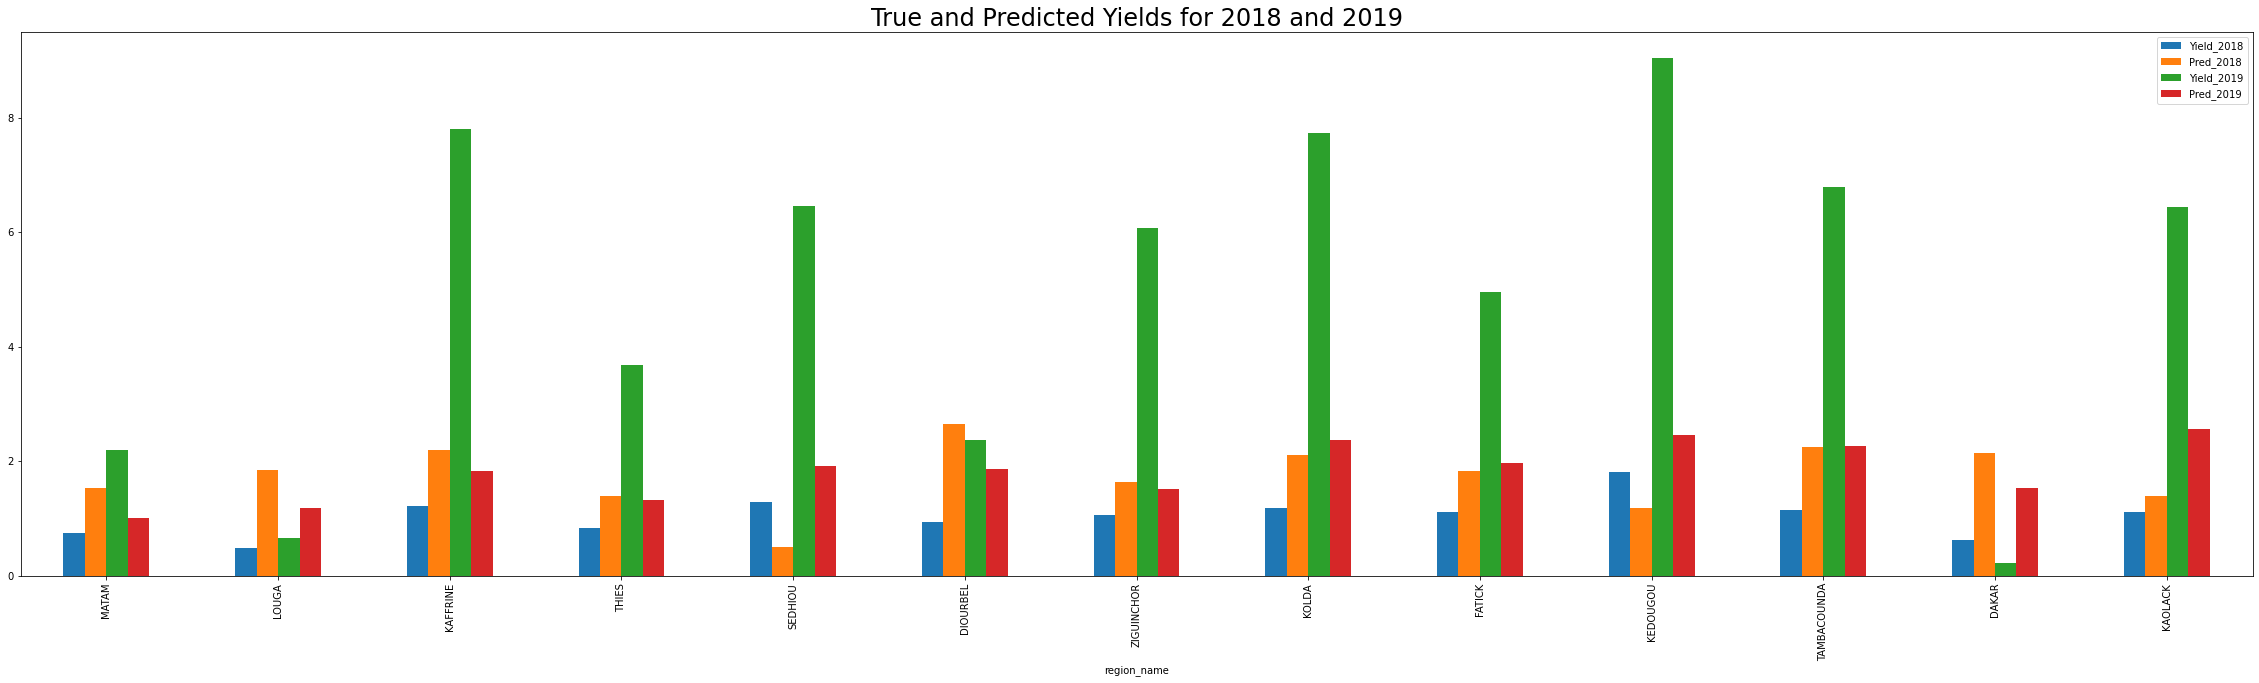

In [58]:
annual_predictions_val_test(df_val_maize, linreg_val_ndvi_window_pred_maize, df_test_maize, linreg_test_ndvi_window_pred_maize, fig_name='linear_ndvi_window_val_test_maize')

             Yield_2016  Yield_2017
region_name                        
KOLDA            2.9040      1.6698
FATICK           1.4014      2.2462
DAKAR            0.9768      0.9350
KEDOUGOU         2.7357      2.7170
TAMBACOUNDA      1.4685      1.5114
SEDHIOU          2.0911      2.2000
THIES            0.6193      0.6116
ZIGUINCHOR       0.9746      2.7247
DIOURBEL         0.8184      0.9009
LOUGA            0.8800      0.6050
MATAM            1.3519      1.3398


<Figure size 432x288 with 0 Axes>

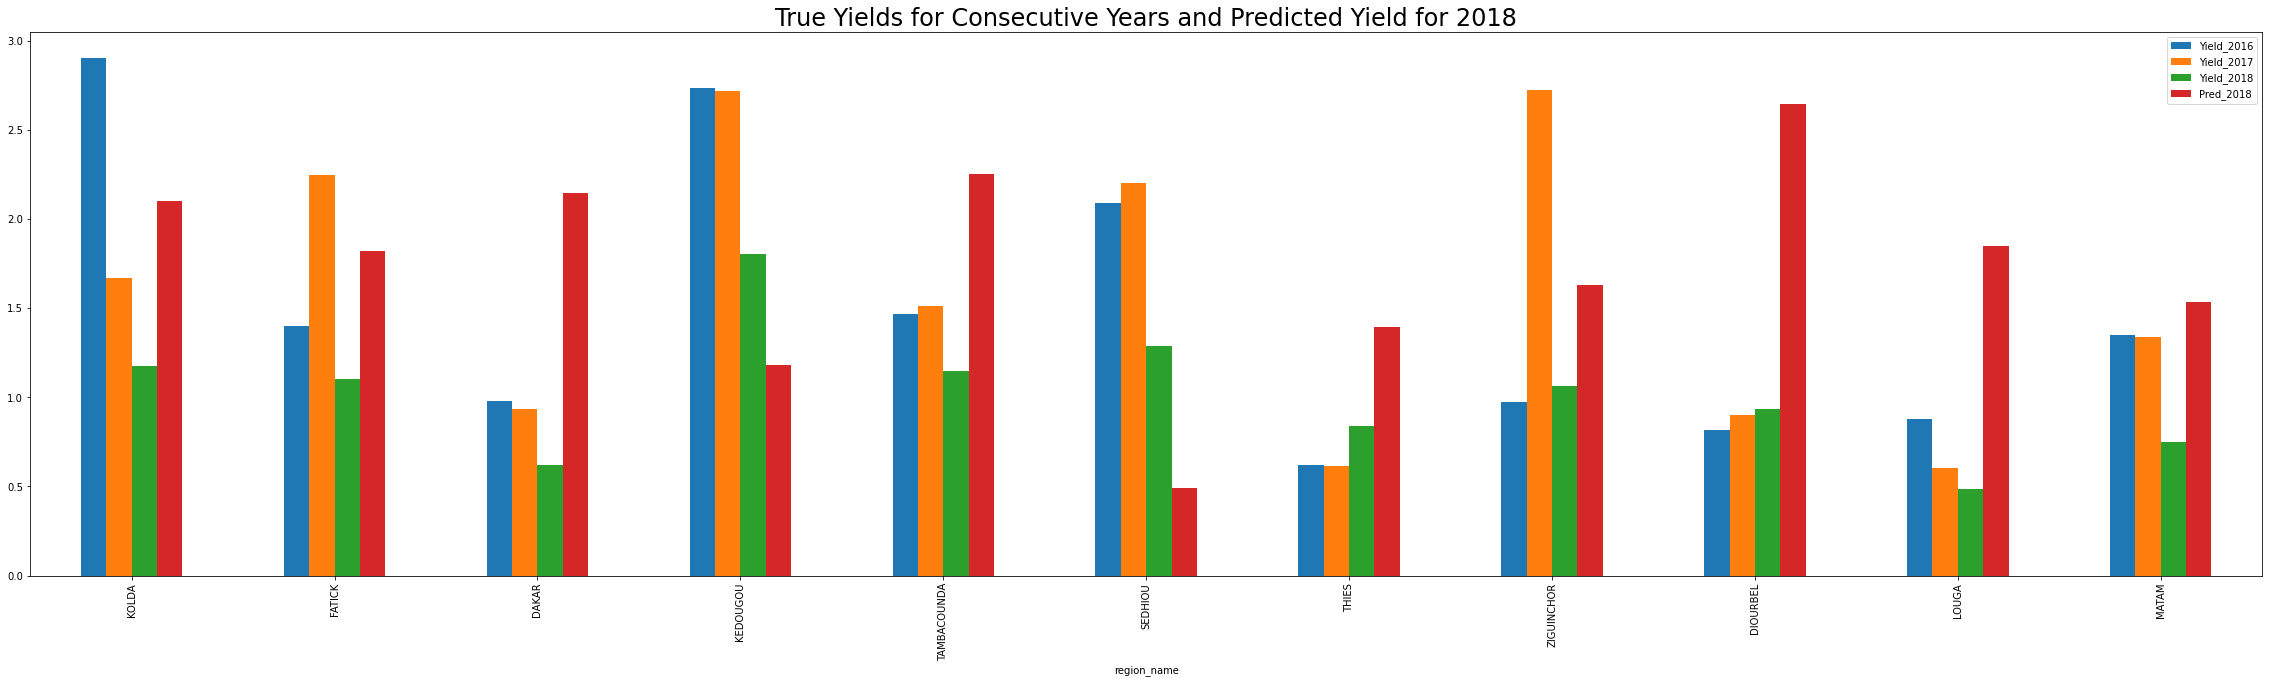

In [59]:
annual_predictions_val_test_years(df_val_maize, linreg_val_ndvi_window_pred_maize, df_train_val_maize, fig_name='linear_ndvi_window_years_maize')

In [60]:
#df_val_sorghum.loc[df_val_sorghum['region_name']=='KAFFRINE']

In [61]:
from sklearn.linear_model import BayesianRidge 

Mean absolute percentage error: 18.666955381427183


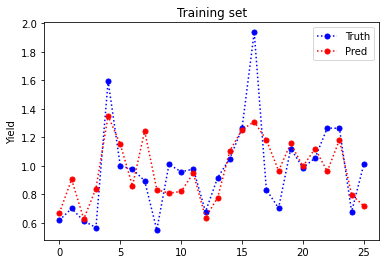

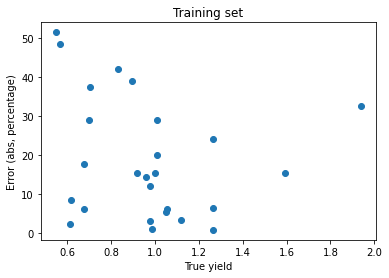

In [62]:
model_bayesian_ridge_max_ndvi_sorghum = BayesianRidge() 
model_bayesian_ridge_max_ndvi_sorghum.fit(max_ndvi_array_sorghum, true_yield_train_sorghum) 
model_bayesian_ridge_max_ndvi_pred_sorghum = model_bayesian_ridge_max_ndvi_sorghum.predict(max_ndvi_array_sorghum)
evaluate_regression(y_array_sorghum, model_bayesian_ridge_max_ndvi_pred_sorghum)

Mean absolute percentage error: 39.67207077348191


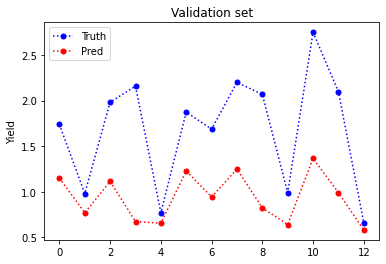

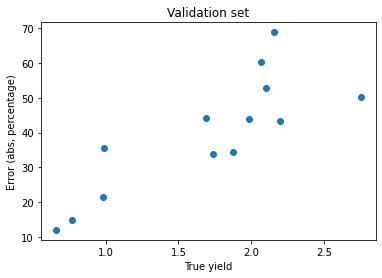

In [63]:
val_feat_max_ndvi_sorghum_2 = val_feat_max_ndvi_sorghum.copy()
val_feat_max_ndvi_sorghum_2 = val_feat_max_ndvi_sorghum_2.to_numpy().reshape(-1, 1)
model_bayesian_ridge_max_ndvi_val_pred_sorghum = model_bayesian_ridge_max_ndvi_sorghum.predict(val_feat_max_ndvi_sorghum_2) 
evaluate_regression(true_yield_val_sorghum, model_bayesian_ridge_max_ndvi_val_pred_sorghum, 'Validation set')

Mean absolute percentage error: 17.734755561962412


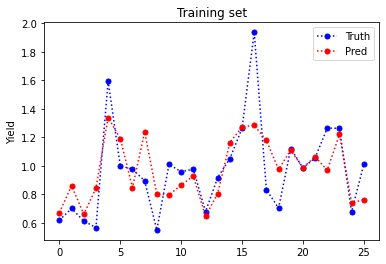

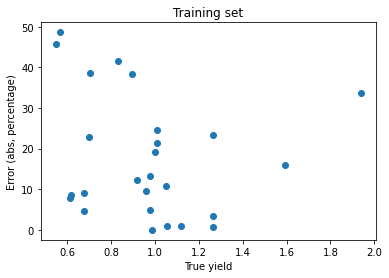

In [64]:
model_bayesian_ridge_ndvi_window_sorghum = BayesianRidge() 
model_bayesian_ridge_ndvi_window_sorghum.fit(ndvi_window_array_sorghum, true_yield_train_sorghum) 
model_bayesian_ridge_ndvi_window_pred_sorghum = model_bayesian_ridge_ndvi_window_sorghum.predict(ndvi_window_array_sorghum)
evaluate_regression(y_array_sorghum, model_bayesian_ridge_ndvi_window_pred_sorghum)

Mean absolute percentage error: 51.63253100030596


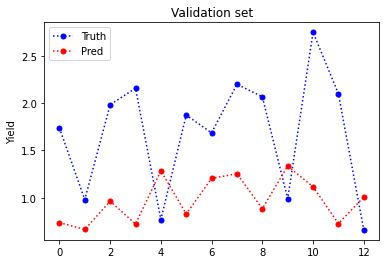

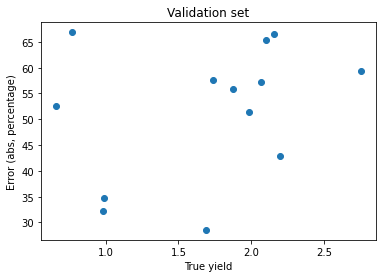

In [65]:
val_feat_ndvi_window_sorghum_2 = val_feat_ndvi_window_sorghum.copy()
#val_feat_ndvi_window_sorghum_2 = val_feat_ndvi_window_sorghum_2.to_numpy().reshape(-1, 1)
model_bayesian_ridge_ndvi_window_val_pred_sorghum = model_bayesian_ridge_ndvi_window_sorghum.predict(val_feat_ndvi_window_sorghum_2) 
evaluate_regression(true_yield_val_sorghum, model_bayesian_ridge_ndvi_window_val_pred_sorghum, 'Validation set')

In [66]:
from sklearn.linear_model import Ridge 

Mean absolute percentage error: 19.80236883554096


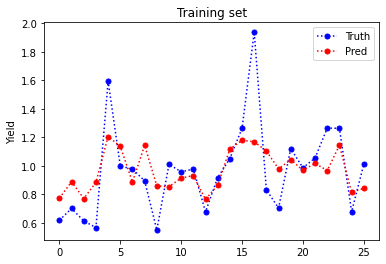

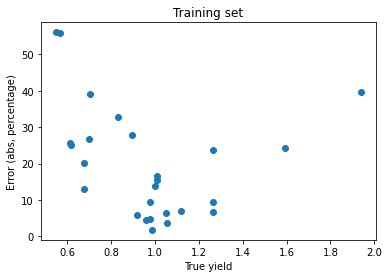

In [67]:
model_ridge_ndvi_window_sorghum = Ridge() 
model_ridge_ndvi_window_sorghum.fit(ndvi_window_array_sorghum, true_yield_train_sorghum) 
model_ridge_ndvi_window_pred_sorghum = model_ridge_ndvi_window_sorghum.predict(ndvi_window_array_sorghum)
evaluate_regression(y_array_sorghum, model_ridge_ndvi_window_pred_sorghum)

Mean absolute percentage error: 47.48578573266107


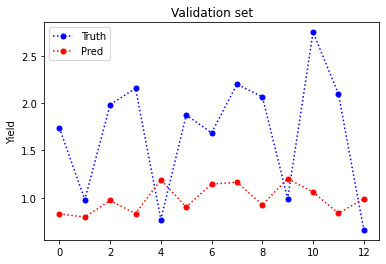

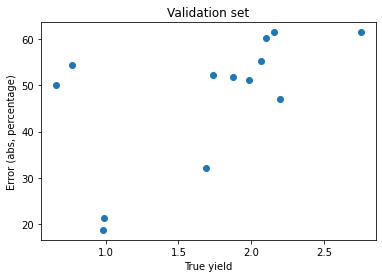

In [68]:
val_feat_ndvi_window_sorghum_2 = val_feat_ndvi_window_sorghum.copy()
#val_feat_ndvi_window_sorghum_2 = val_feat_ndvi_window_sorghum_2.to_numpy().reshape(-1, 1)
model_ridge_ndvi_window_val_pred_sorghum = model_ridge_ndvi_window_sorghum.predict(val_feat_ndvi_window_sorghum_2) 
evaluate_regression(true_yield_val_sorghum, model_ridge_ndvi_window_val_pred_sorghum, 'Validation set')

In [69]:
from sklearn.linear_model import Lasso

In [70]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LassoCV

In [71]:
model_lasso_ndvi_window_sorghum_test = Lasso() 
cv = RepeatedKFold(n_splits=2, n_repeats=10, random_state=1)
# define grid
grid = dict()
grid['alpha'] = np.arange(0, 1, 0.01)
# define search
search_lasso = GridSearchCV(model_lasso_ndvi_window_sorghum_test, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# perform the search
results_lasso = search_lasso.fit(ndvi_window_array_sorghum, true_yield_train_sorghum)

In [72]:
print('MAE: %.3f' % results_lasso.best_score_)
print('Config: %s' % results_lasso.best_params_)

MAE: -0.219
Config: {'alpha': 0.01}


In [73]:
model_lasso_ndvi_window_sorghum = Lasso(alpha = results_lasso.best_params_['alpha']) 
model_lasso_ndvi_window_sorghum.fit(ndvi_window_array_sorghum, true_yield_train_sorghum)

Lasso(alpha=0.01)

In [74]:
model_lasso_ndvi_window_pred_sorghum = model_lasso_ndvi_window_sorghum.predict(ndvi_window_array_sorghum)

Mean absolute percentage error: 20.242935653856115


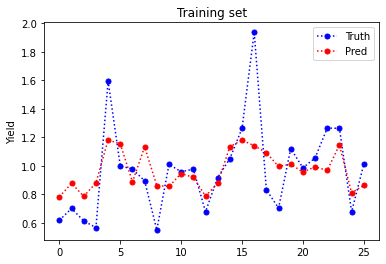

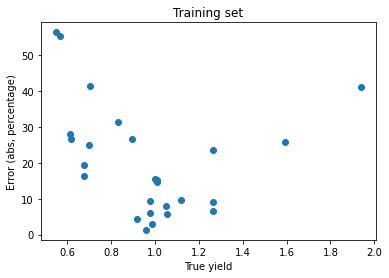

In [75]:
evaluate_regression(y_array_sorghum, model_lasso_ndvi_window_pred_sorghum)

Mean absolute percentage error: 45.74610081749465


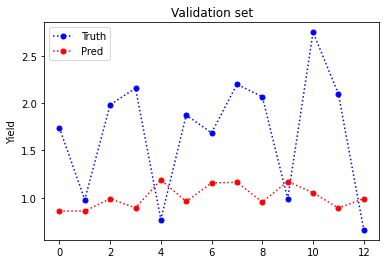

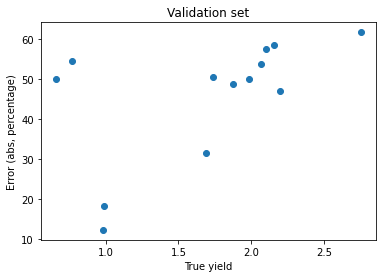

In [76]:
model_lasso_ndvi_window_val_pred_sorghum = model_lasso_ndvi_window_sorghum.predict(val_feat_ndvi_window_sorghum_2) 
evaluate_regression(true_yield_val_sorghum, model_lasso_ndvi_window_val_pred_sorghum, 'Validation set')

In [77]:
#df_test_sorghum, test_feat_ndvi_window_sorghum = prepare_test_set()
bayesian_ridge_test_ndvi_window_pred_sorghum = model_bayesian_ridge_ndvi_window_sorghum.predict(test_feat_ndvi_window_sorghum)

             Yield_2018  Pred_2018
region_name                       
MATAM            0.7513   0.737148
LOUGA            0.4873   0.664853
KAFFRINE         1.2100   0.963354
THIES            0.8360   0.722757
SEDHIOU          1.2848   1.284893
DIOURBEL         0.9339   0.828901
ZIGUINCHOR       1.0604   1.204780
KOLDA            1.1726   1.254683
FATICK           1.1033   0.885170
KEDOUGOU         1.8062   1.334530
TAMBACOUNDA      1.1473   1.116014
DAKAR            0.6215   0.727325
KAOLACK          1.1055   1.007172


<Figure size 432x288 with 0 Axes>

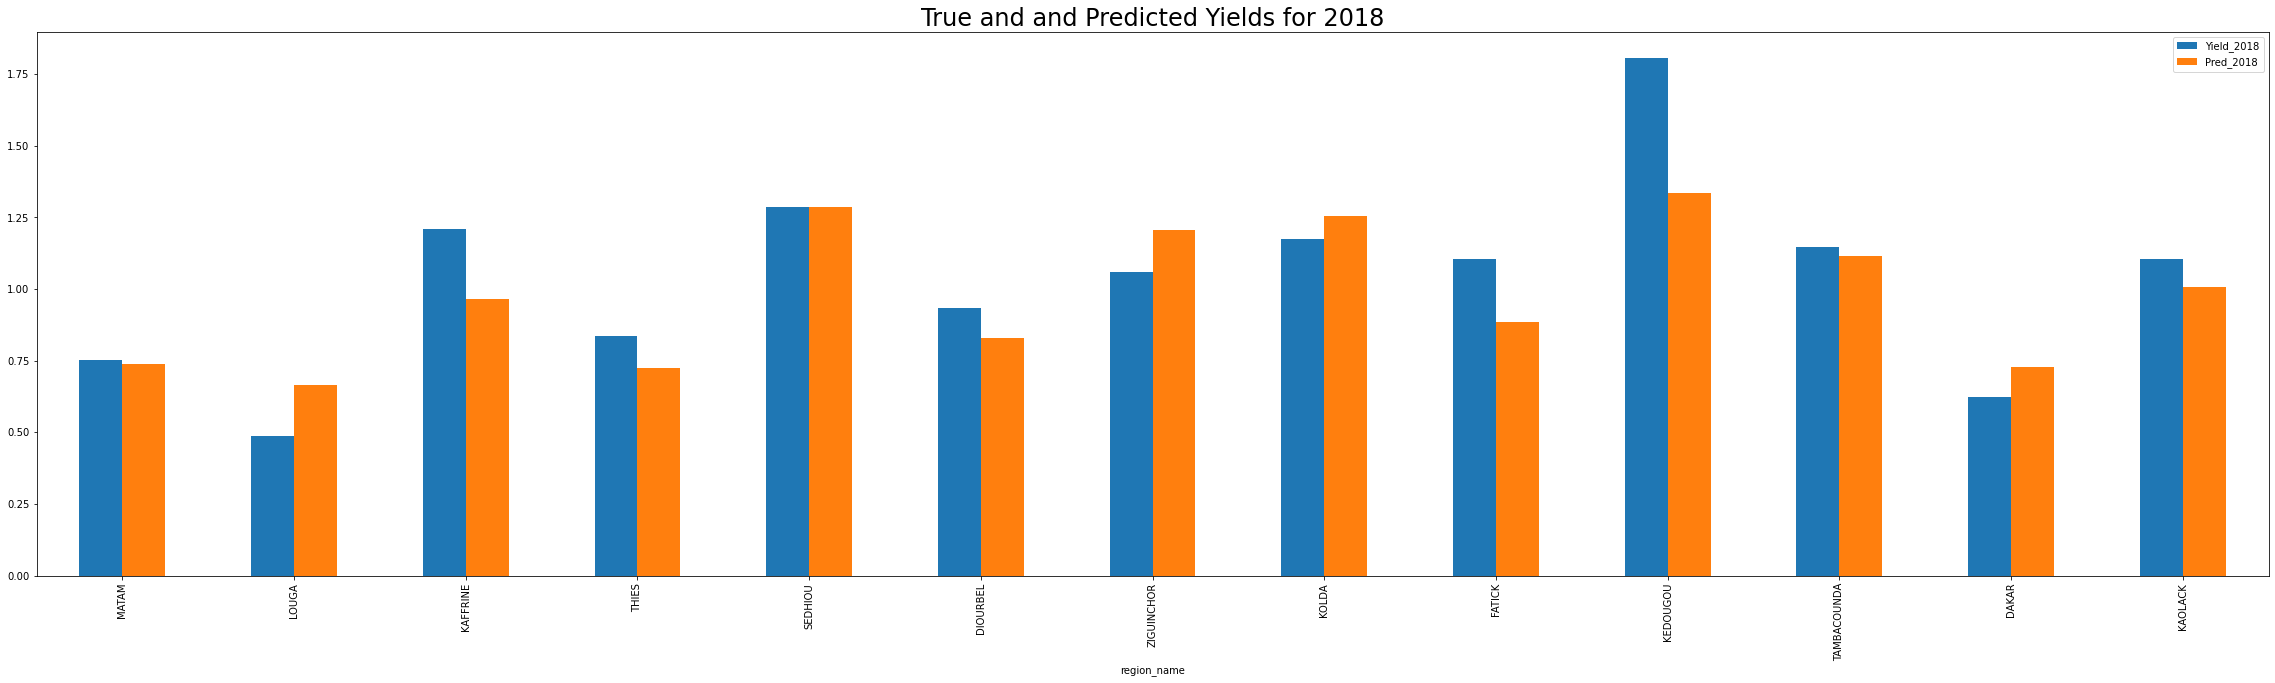

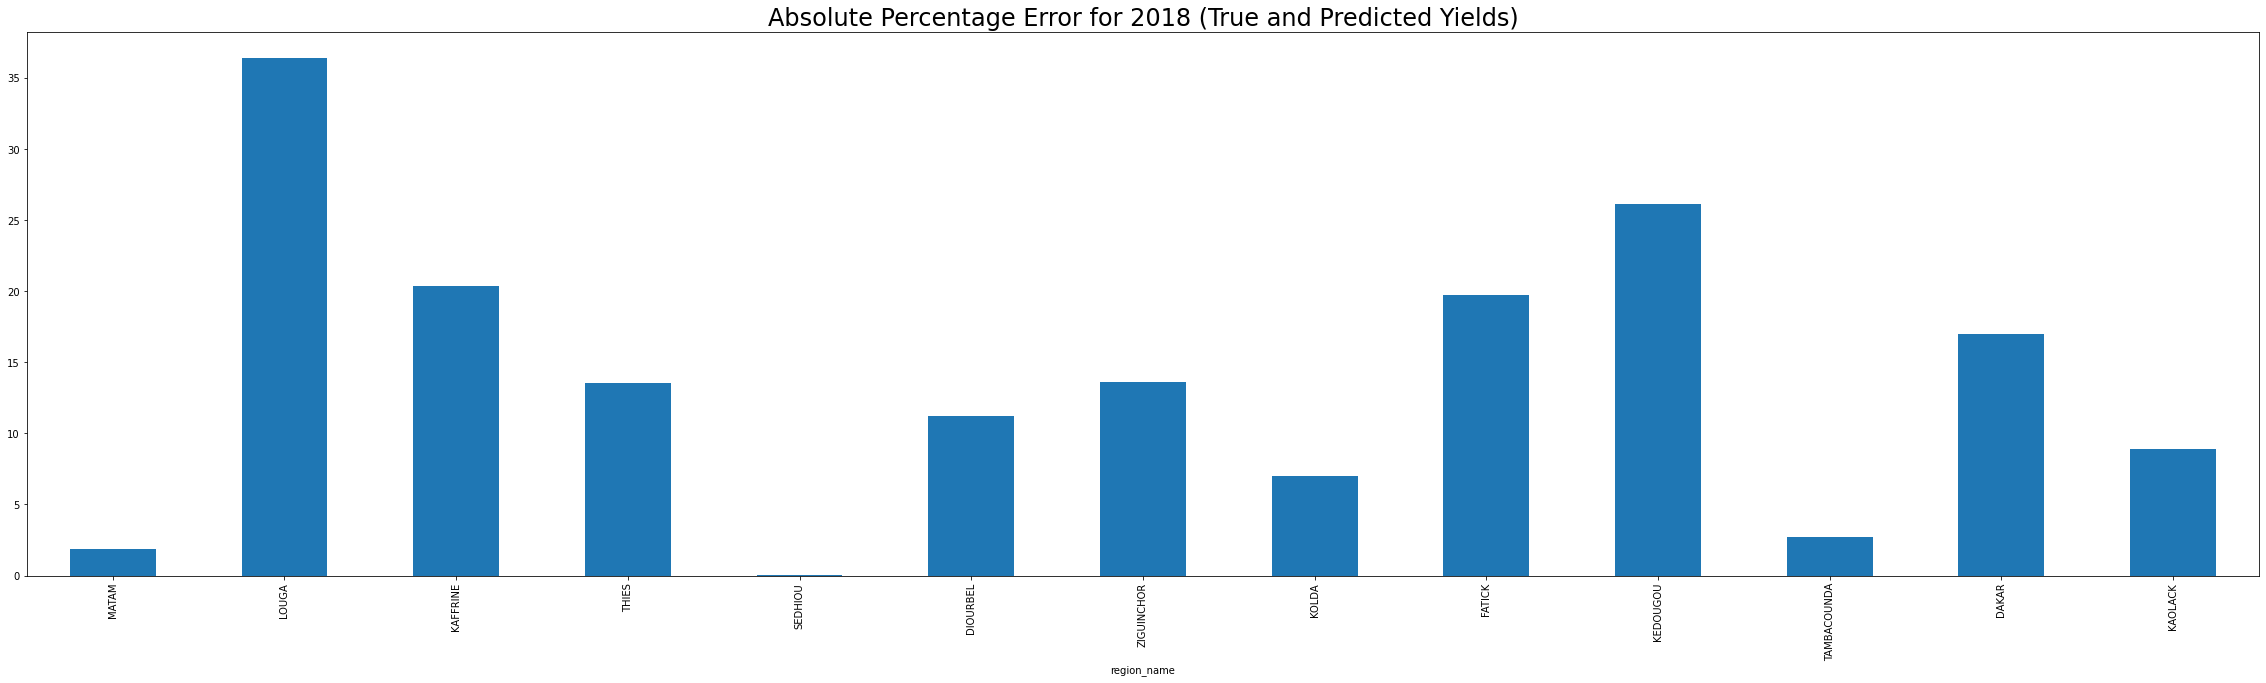

<Figure size 432x288 with 0 Axes>

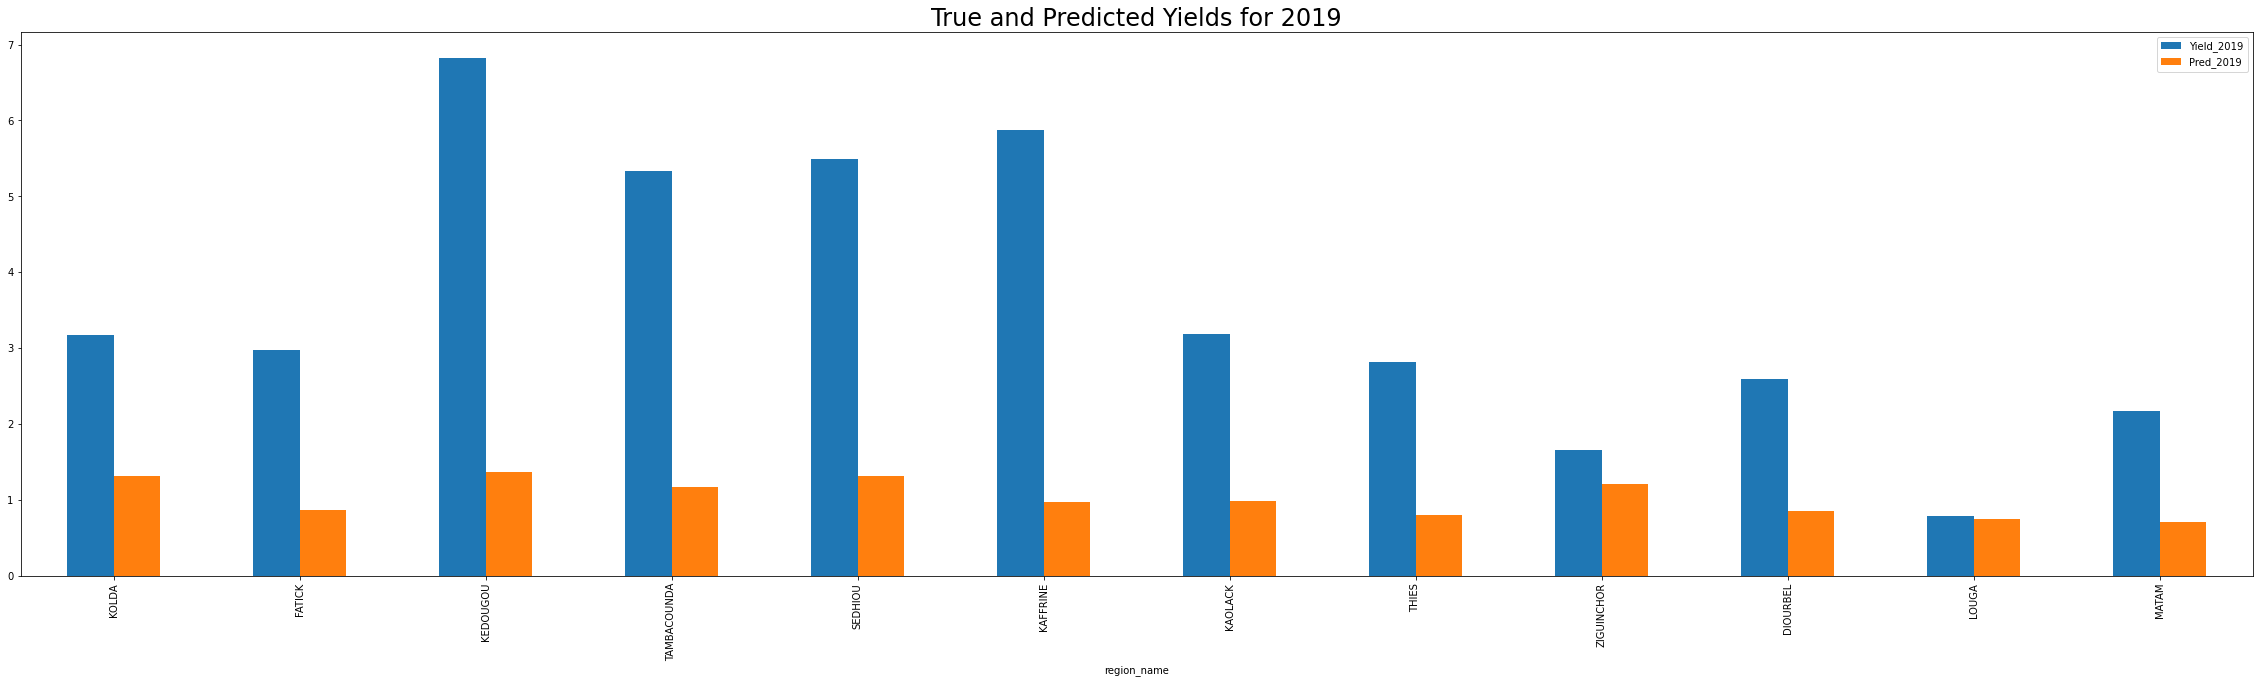

<Figure size 432x288 with 0 Axes>

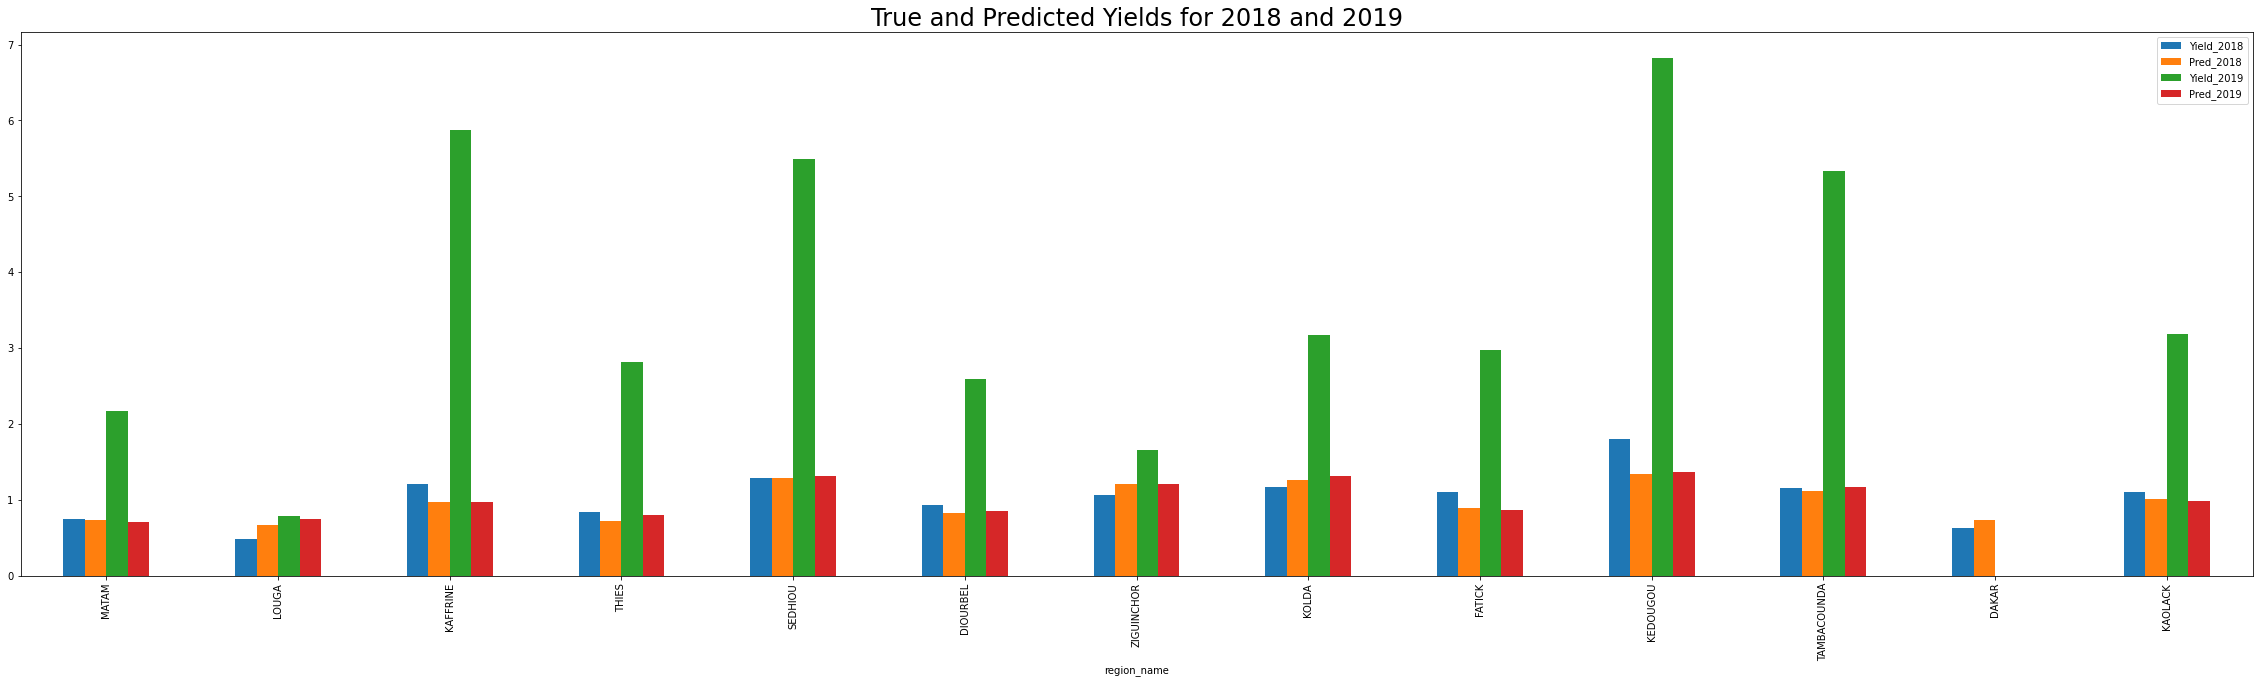

In [78]:
annual_predictions_val_test(df_val_sorghum, model_bayesian_ridge_ndvi_window_val_pred_sorghum, df_test_sorghum, bayesian_ridge_test_ndvi_window_pred_sorghum, fig_name='bayesian_ridge_ndvi_window_val_test_sorghum')

             Yield_2016  Yield_2017
region_name                        
KOLDA            0.8943      0.8316
FATICK           0.9581      0.9768
DAKAR            0.5665      0.5500
KEDOUGOU         1.5939      1.9371
TAMBACOUNDA      1.1209      1.0549
SEDHIOU          1.2628      1.2628
KAFFRINE         1.2650      0.9768
KAOLACK          0.7029      0.9856
THIES            1.0098      1.0098
ZIGUINCHOR       0.9988      1.0505
DIOURBEL         0.9174      0.7007
LOUGA            0.6127      0.6182
MATAM            0.6776      0.6776


<Figure size 432x288 with 0 Axes>

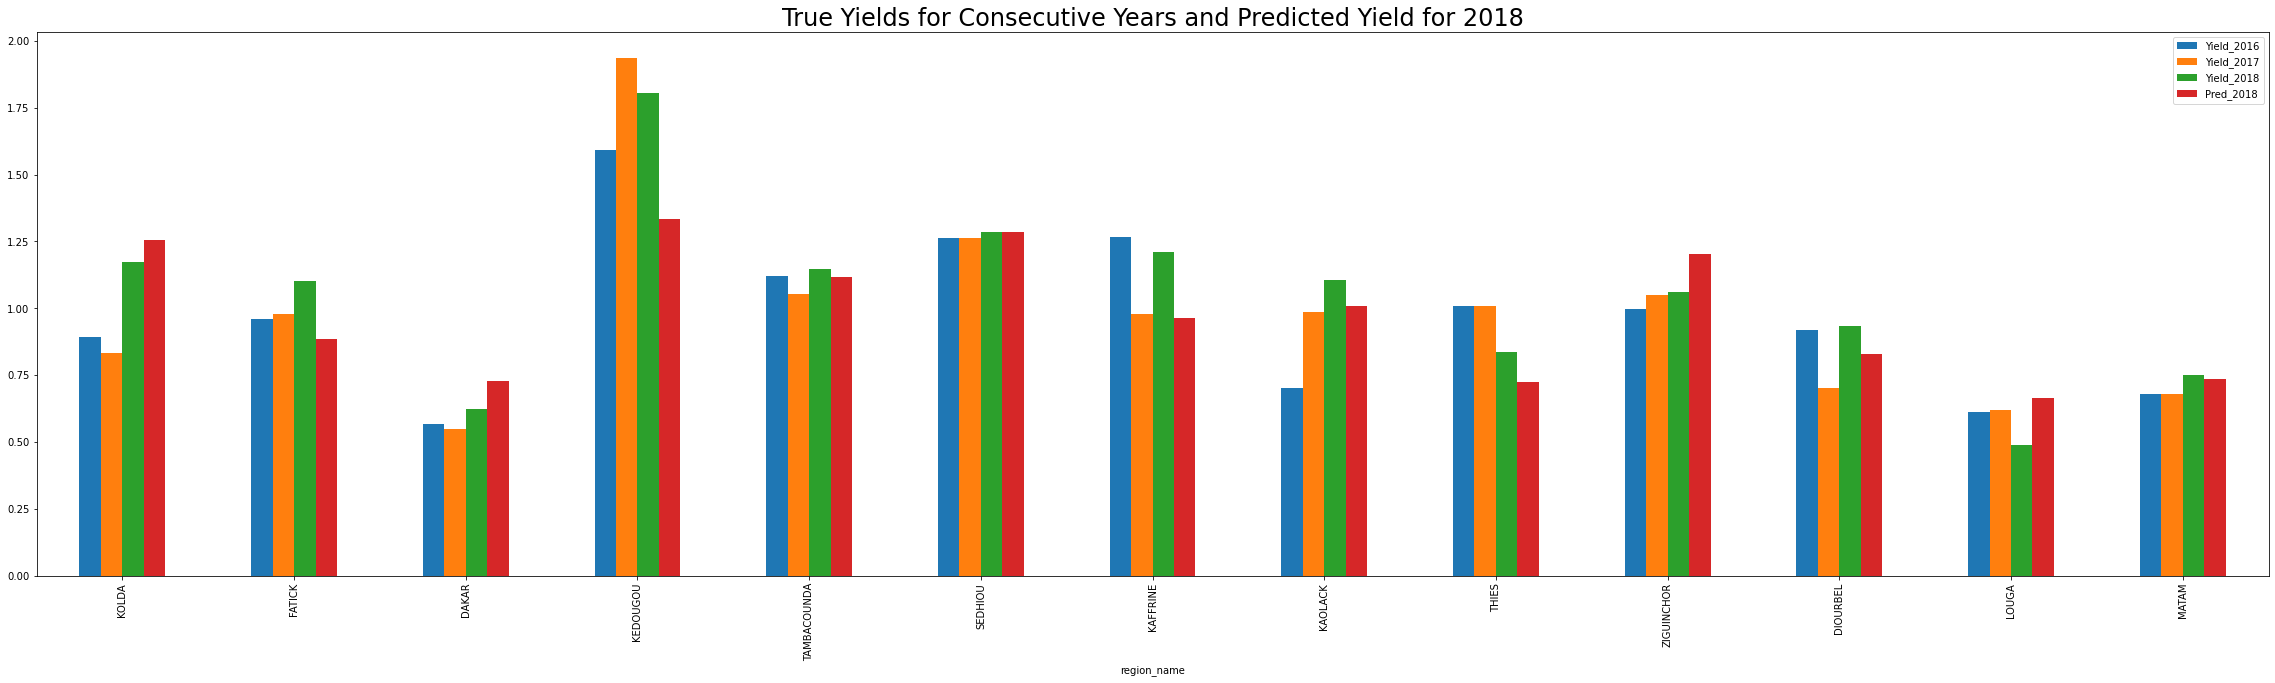

In [79]:
annual_predictions_val_test_years(df_val_sorghum, model_bayesian_ridge_ndvi_window_val_pred_sorghum, df_train_val_sorghum, fig_name='bayesian_ridge_ndvi_window_years_sorghum')